In [1]:
#import tensorflow as tf
#print(tf.__version__)
#2.13.0

In [2]:
#!pip uninstall tensorflow keras -y
#!pip install tensorflow==2.15.0
#!pip install TA-Lib


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.base import BaseEstimator
import time
import yfinance as yf


import time
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2

#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd, BDay, Week

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean

import pandas_ta as ta

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:


def plot_predictions(data, train_predictions, test_predictions, scaler):
    """
    Plot actual data along with train and test predictions, using dates on the x-axis.

    Parameters:
    - data: The original DataFrame containing the actual target values.
    - train_predictions: Predicted values for the train dataset (scaled).
    - test_predictions: Predicted values for the test dataset (scaled).
    - scaler: Fitted scaler object used to inverse transform the scaled predictions.
    """
    # Ensure the index is used as the x-axis (datetime index)
    dates = data.index

    # Inverse transform the actual data to the original scale
    actual_data2 = data['Log_Return'].values.reshape(-1, 1)
    actual_data = scaler.inverse_transform(data['Log_Return'].values.reshape(-1, 1))

    # Prepare placeholders for plotting train and test predictions
    train_predict_plot = np.empty_like(actual_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[:len(train_predictions)] = scaler.inverse_transform(train_predictions.reshape(-1, 1))

    test_predict_plot = np.empty_like(actual_data)
    test_predict_plot[:] = np.nan
    test_predict_plot[len(train_predictions):len(train_predictions) + len(test_predictions)] = scaler.inverse_transform(test_predictions.reshape(-1, 1))

    train_dates = data.index[:len(train_predictions)]
    test_dates = data.index[len(train_predictions):len(train_predictions) + len(test_predictions)]

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Log_Return'], label="Actual Data", color="blue")
    plt.plot(train_dates, scaler.inverse_transform(train_predictions.reshape(-1, 1)), label="Train Predictions", color="orange")
    plt.plot(test_dates, scaler.inverse_transform(test_predictions.reshape(-1, 1)), label="Test Predictions", color="green")
    plt.title("Train and Test Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value (Original Scale)")
    plt.legend()
    plt.grid()
    plt.show()

    
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Computes the Mean Absolute Scaled Error (MASE).
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    
    Returns:
    - MASE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    naive_forecast = np.roll(y_true, shift=1)  # Naïve forecast: previous value as the next
    naive_forecast[0] = y_true[0]  # First value remains the same to avoid shifting issues
    naive_mae = np.mean(np.abs(y_true - naive_forecast))  # Baseline error
    mase = np.mean(np.abs(y_true - y_pred)) / naive_mae if naive_mae != 0 else np.nan  # Avoid division by zero
    return mase


def calculate_metrics(y_true, y_pred, scaler):
    """
    Calculates RMSE and MAE evaluation metrics before and after inverse transformation.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    - scaler: The target scaler used for inverse transformation.
    
    Returns:
    - RMSE and MAE values before and after inverse transformation.
    """
    # Compute metrics before inverse transformation
    rmse_scaled = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_scaled = mean_absolute_error(y_true, y_pred)
    
    #print(f"Scaled RMSE: {rmse_scaled}, Scaled MAE: {mae_scaled}")
    
    # Compute metrics after inverse transformation
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    epsilon=1e-8
    rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_original = mean_absolute_error(y_true_original, y_pred_original)
    mase_original = mean_absolute_scaled_error(y_true_original , y_pred_original) 
    
    #print(f"Original RMSE: {rmse_original}, Original MAE: {mae_original}")
    
    return rmse_original, mae_original, mase_original

In [5]:
# =============================================================================
# Function 1: Create Multi-Feature Time-Series Data (Target = LogReturn)
# =============================================================================
def create_time_series_data(data, look_back=10):
    """
    Converts a 2D NumPy array of shape (num_samples, num_features)
    into time-series arrays for LSTM.
    
    Here the target (y) is set to the value of the first column (LogReturn)
    at time (i + look_back).
    
    Returns:
      X: Array of shape (num_samples - look_back, look_back, num_features)
      y: Array of shape (num_samples - look_back,) – the target log returns.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, :])
        # Target is now the next day's LogReturn (assumed to be column 0)
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

# =============================================================================
# Function 2: Split Data & Compute Features (LogReturn and SMAs)
# =============================================================================

def split_data(data, windows, look_back, train_start, train_end, test_start, test_end):
    """
    1. Computes log returns.
    2. Computes SMAs for each window in sma_windows.
    3. Adds seasonality features (month, quarter, week of the year, and day of week).
    4. Drops NaN values.
    5. Splits data into train and test sets based on date ranges.
    6. Creates time-series arrays (X, y) where y is the next day's log return.
    
    Returns:
      X_train, X_test, y_train, y_test, feature_cols
    """
    # Compute seasonality features
    data['Month'] = data.index.month
    data['Quarter'] = data.index.quarter
    data['WeekOfYear'] = data.index.isocalendar().week
    data['DayOfWeek'] = data.index.dayofweek
    
    data = data.copy()
    # Compute log returns
    data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Compute SMAs for each window size
    for w in windows:
        data[f'SMA_{w}'] = data['Close'].rolling(window=w).mean()
        data[f'EMA_{w}'] = data['Close'].ewm(span=w, adjust=False).mean()
        
    # Compute Volatility as 20-day Rolling Standard Deviation
    data['Volatility'] = data['LogReturn'].rolling(window=20).std()

    data.dropna(inplace=True)
    
    train_size = int(len(data) * 0.75)
    train_data, test_data = data[:train_size], data[train_size:]
    
    print(train_data.shape)
    print(test_data.shape)
    
    # Feature order: LogReturn, SMAs, Seasonality, Close
    feature_cols = ['LogReturn'] + [f'SMA_{w}' for w in windows] + \
                   [f'EMA_{w}' for w in windows] + \
                   ['Volatility', 'Month', 'Quarter', 'WeekOfYear', 'DayOfWeek', 'Close'] 
    
    

    X_train, y_train = create_time_series_data(train_data[feature_cols].values, look_back)
    X_test,  y_test  = create_time_series_data(test_data[feature_cols].values, look_back)
    
    return X_train, X_test, y_train, y_test, feature_cols


# =============================================================================

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_residual_analysis(y_true_scaled, predictions_scaled, target_scaler, title_prefix="Train"):
    """
    Plots residuals vs time and histogram of residuals using original-scale targets.

    Parameters:
    - y_true_scaled: Scaled true target values.
    - predictions_scaled: Scaled predicted target values.
    - target_scaler: Scaler used to inverse-transform scaled predictions.
    - title_prefix: Prefix for plot titles (e.g., 'Train' or 'Test').
    """
    # Inverse-transform scaled values to original scale
    y_true = target_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()
    predictions = target_scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()

    # Calculate residuals in original scale
    residuals = y_true - predictions

    # Create a 1x2 plot (Removing ACF plot)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'{title_prefix} Residual Analysis (Original Scale)', fontsize=16)

    # 1. Residuals vs Time
    axes[0].plot(residuals, marker='o', linestyle='none', alpha=0.7)
    axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[0].set_title('Residuals vs Time')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Residuals (Original Scale)')

    # 2. Histogram of Residuals
    sns.histplot(residuals, bins=30, kde=True, ax=axes[1], color='skyblue')
    axes[1].set_title('Histogram of Residuals')
    axes[1].set_xlabel('Residuals (Original Scale)')
    axes[1].set_ylabel('Frequency')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [7]:
# =============================================================================
# Function 3: Scale the Data
# =============================================================================
def scale_data(X_train, X_test, y_train, y_test):
    """
    Scales the features and target.
    The feature scaler is applied to the flattened feature set and then reshaped back.
    """
    feature_scaler = MinMaxScaler()
    target_scaler  = MinMaxScaler()
    
    n_train, lb, nf = X_train.shape
    X_train_2d = X_train.reshape(n_train * lb, nf)
    n_test, lb_test, nf_test = X_test.shape
    X_test_2d = X_test.reshape(n_test * lb_test, nf_test)
    
    X_train_scaled_2d = feature_scaler.fit_transform(X_train_2d)
    X_test_scaled_2d  = feature_scaler.transform(X_test_2d)
    
    X_train_scaled = X_train_scaled_2d.reshape(n_train, lb, nf)
    X_test_scaled  = X_test_scaled_2d.reshape(n_test, lb_test, nf_test)
    
    # Scale target (log returns)
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled  = target_scaler.transform(y_test.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

# =============================================================================
# Function 4: Build LSTM Model
# =============================================================================
def build_lstm_model2(units, dropout, learning_rate, look_back, num_features):
    
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation='relu', return_sequences=True), 
                            input_shape=(look_back, num_features)))
    model.add(Bidirectional(LSTM(units // 2, activation='relu'
                                 )))
    model.add(Dropout(dropout))  
    model.add(Dense(1))  
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    
    
    return model
def build_lstm_model(units, dropout, learning_rate, look_back, num_features):
    
    model = Sequential()
    
    # First Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(units, activation='tanh', return_sequences=True), 
                            input_shape=(look_back, num_features)))
    model.add(Dropout(dropout))
    model.add(LSTM(units // 2, activation='tanh', return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(units // 4, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    
    return model

# =============================================================================
# Function 5: LSTMRegressor (Sklearn Wrapper)
# =============================================================================
##

class LSTMRegressor(BaseEstimator):
    def __init__(self, units=64, dropout=0.2, learning_rate=0.01, epochs=10, batch_size=32, look_back=10, num_features=5):
        self.units = units
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.look_back = look_back
        self.num_features = num_features
        self.model_ = None
        
    def fit(self, X, y):
        self.model_ = build_lstm_model(self.units, self.dropout, self.learning_rate, self.look_back, self.num_features)
        #self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        
        # Early Stopping Callback
        early_stopping = EarlyStopping(
            monitor='val_loss',        # Monitor validation loss
            patience=5,                # Stop if no improvement in 5 epochs
            restore_best_weights=True  # Roll back to best model
        )
        
        # Fit with Early Stopping
        self.model_.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=0.2,    # Reserve 20% of training data for validation
            callbacks=[early_stopping],
            verbose=0
        )
        
        return self
    
    def predict(self, X):
        return self.model_.predict(X, verbose=0)

# =============================================================================
# Function 6: Bayesian Hyperparameter Optimization for LSTMRegressor
# =============================================================================
def model_training(X_train_scaled, y_train_scaled, look_back, num_features):
    """param_space = {
        'units': Categorical([64, 128]),
        'dropout': Categorical([0.2, 0.3, 0.4]),
        'learning_rate': Categorical([0.001, 0.01, 0.05]),
    }"""
    
    param_space = {
    'units': Integer(32, 128),                           # Reduced range to speed up
    'dropout': Real(0.2, 0.4),                          # Narrower range for faster convergence
    'learning_rate': Real(0.003, 0.01, prior='log-uniform'),  # Faster convergence range
    #'batch_size': Categorical([16, 32, 64])                     # Fixed batch size for speed
    }
    

    
    estimator = LSTMRegressor(look_back=look_back, num_features=num_features)
    bayes_search = BayesSearchCV(estimator, param_space, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
    
    y_train_scaled_2d = y_train_scaled.reshape(-1, 1)
    bayes_search.fit(X_train_scaled, y_train_scaled_2d)

    print("Best Model Parameters:", bayes_search.best_params_)
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    return best_model, best_params

# =============================================================================
# Function 7: Train Final Model on Full Dataset
# =============================================================================
def train_final_model(data, sma_windows, feature_scaler, target_scaler, best_params, look_back, num_features):
    X_full, _, y_full, _, _ = split_data(data, sma_windows, look_back, "2000-01-01", "2023-12-31", None, None)

    n_full, lb, nf = X_full.shape
    X_full_2d = X_full.reshape(n_full * lb, nf)
    X_full_scaled_2d = feature_scaler.transform(X_full_2d)
    X_full_scaled = X_full_scaled_2d.reshape(n_full, lb, nf)

    y_full_scaled = target_scaler.transform(y_full.reshape(-1, 1))

    # Step 1: **Train Model on Full Data First (Reduce Epochs to 10)**
    final_model = LSTMRegressor(
        units=best_params['units'],
        dropout=best_params['dropout'],
        learning_rate=best_params['learning_rate'],
        epochs=20,  # 
        batch_size=32,
        look_back=look_back,
        num_features=num_features
    )

    final_model.fit(X_full_scaled, y_full_scaled)  
    
    
    return final_model


# =============================================================================

In [8]:
def forecast_future_multi_step(
    data,
    model,
    feature_scaler,
    target_scaler,
    windows,
    look_back,
    start_date="2024-01-01",
    end_date="2024-12-31"
):
    """
    Recursively forecasts future log returns and computes forecasted 'Close' prices
    from those log returns for every business day between start_date and end_date.
    """

    import sys
    data = data.copy()

    # Compute LogReturn if not present
    if 'LogReturn' not in data.columns:
        data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))

    # Compute SMAs if not present
    for w in windows:
        sma_col = f'SMA_{w}'
        ema_col = f'EMA_{w}'
        if sma_col not in data.columns:
            data[sma_col] = data['Close'].rolling(window=w).mean()
        if ema_col not in data.columns:
            data[ema_col] = data['Close'].ewm(span=w, adjust=False).mean()
            
    # Compute seasonality features
    data['Month'] = data.index.month
    data['Quarter'] = data.index.quarter
    data['WeekOfYear'] = data.index.isocalendar().week
    data['DayOfWeek'] = data.index.dayofweek
    
    if 'Volatility' not in data.columns:
        data['Volatility'] = data['LogReturn'].rolling(window=20).std()

    data.dropna(inplace=True)

    # Ensure index is DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    # Initialize forecast_df with all data before start_date.
    forecast_df = data[data.index < start_date].copy()
    if forecast_df.empty:
        forecast_df = data.copy()

    # Define feature order (same as training)
    #feature_cols = ['LogReturn'] + [f'SMA_{w}' for w in sma_windows] + ['Month', 'Quarter', 'WeekOfYear', 'DayOfWeek', 'Close']
    feature_cols = ['LogReturn'] + [f'SMA_{w}' for w in windows] + \
                       [f'EMA_{w}' for w in windows] + \
                       ['Volatility', 'Month', 'Quarter', 'WeekOfYear', 'DayOfWeek', 'Close'] 
    
    # Prepare 3-year rolling window for quantile calculation
    three_year_window = 756  # Approx. 3 years of trading days (252 days per year)
    historical_log_returns = data['LogReturn'].tail(three_year_window).tolist()

    # Generate future business dates
    future_dates = pd.date_range(start=start_date, end=end_date, freq='B')
    predictions = []

    for i, date in enumerate(future_dates):
        last_window = forecast_df.iloc[-look_back:].copy()
        if len(last_window) < look_back:
            break  # Stop if not enough data

        # Ensure no NaNs in the look-back window
        if last_window.isna().sum().sum() > 0:
            print(f"Warning: NaN detected in look-back window at step {i+1}")
            print(last_window.tail(3))  # Debugging

        # Transform features
        last_window_2d = last_window[feature_cols].values
        scaled_2d = feature_scaler.transform(last_window_2d)
        X_3d = scaled_2d.reshape(1, look_back, len(feature_cols))
        
        # Predict log return
        scaled_pred_log_return = model.predict(X_3d)[0][0]
        pred_log_return = target_scaler.inverse_transform([[scaled_pred_log_return]])[0][0]
        
        
        # Get the previous log return (for smoothing)
        prev_log_return = forecast_df['LogReturn'].iloc[-1] 
         
        
        # Compute dynamic capping thresholds from historical data
        #log_return_low = data['LogReturn'].quantile(0.01)  # 1% percentile
        #log_return_high = data['LogReturn'].quantile(0.99)  # 99% percentile

        # Dynamically compute quantiles based on the 3-year rolling window
        lower_threshold = np.quantile(historical_log_returns, 0.01)  # 1st percentile
        upper_threshold = np.quantile(historical_log_returns, 0.99)  # 99th percentile

        # Check if the predicted value exceeds ±2%
        #if pred_log_return > 0.04:
        #    smooth_factor = 0.75  # Stronger smoothing for extreme values
        #    pred_log_return = smooth_factor * log_return_high + (1 - smooth_factor) * prev_log_return
        #elif pred_log_return < -0.04:
        #    smooth_factor = 0.75
        #    pred_log_return = smooth_factor * log_return_low + (1 - smooth_factor) * prev_log_return

        smooth_factor = 0.75
        # Apply smoothing if forecasted value exceeds the quantile-based threshold
        if pred_log_return > 0.04:
            pred_log_return = smooth_factor * upper_threshold + (1 - smooth_factor) * prev_log_return
        elif pred_log_return < -0.04:
            pred_log_return = smooth_factor * lower_threshold + (1 - smooth_factor) * prev_log_return

            
        # Prevent NaN predictions
        if np.isnan(pred_log_return):
            print(f"Warning: NaN detected at step {i+1}. Replacing with 0.")
            pred_log_return = 0.0
            print(last_window)

        # Compute predicted Close price
        prev_close = forecast_df['Close'].iloc[-1]
        pred_close = prev_close * np.exp(pred_log_return)

        # Store first few predictions for debugging
        if i < 5:
            print(f"Step {i+1}: Date={date}, Pred_LogReturn={pred_log_return}, Pred_Close={pred_close}")

        # Append new row with all required fields
        new_row = pd.DataFrame({
            'LogReturn': [pred_log_return],
            'Close': [pred_close],
            'Month': [date.month],
            'Quarter': [date.quarter],
            'WeekOfYear': [date.isocalendar()[1]],
            'DayOfWeek': [date.weekday()]
        }, index=[date])
        #print(new_row)
        # Append properly to maintain rolling computations
        forecast_df = pd.concat([forecast_df, new_row])

        # Recalculate rolling SMAs dynamically
        for w in windows:
            forecast_df[f'SMA_{w}'] = forecast_df['Close'].rolling(window=w).mean()

        # Fill missing values dynamically
        for w in windows:
            forecast_df[f'SMA_{w}'].fillna(forecast_df['Close'], inplace=True)

        # Recalculate rolling EMAs dynamically
        for w in windows:
            forecast_df[f'EMA_{w}'] = forecast_df['Close'].ewm(span=w, adjust=False).mean()

        # Fill missing values dynamically
        for w in windows:
            forecast_df[f'EMA_{w}'].fillna(forecast_df['Close'], inplace=True)

        forecast_df['Volatility'] = forecast_df['LogReturn'].rolling(window=20).std()
    
        # Store values
        predictions.append((date, pred_log_return))

        # Update the 3-year rolling window with the latest forecast
        historical_log_returns.append(pred_log_return)
        if len(historical_log_returns) > three_year_window:
            historical_log_returns.pop(0)  # Maintain 3-year length
            
    # Final dataframe with predictions
    pred_df = pd.DataFrame(predictions, columns=['Date', 'Forecasted_Log_Return']).set_index('Date')

    return pred_df, forecast_df


In [9]:
# =============================================================================
# Function 9: Main Function to Run the Pipeline (Now for LogReturn Forecasting)
# =============================================================================
def main(data):
    look_back = 10
    windows = [5, 10, 30]
    train_start, train_end = "2000-01-01", "2014-12-31"
    test_start, test_end   = "2015-01-01", "2024-01-01"
    
    # 9.1) Split data and compute features.
    X_train, X_test, y_train, y_test, feature_cols = split_data(data, windows, look_back,
                                                                 train_start, train_end,
                                                                 test_start, test_end)
    # 9.2) Scale the data.
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(X_train, X_test, y_train, y_test)
    _, _, num_features = X_train_scaled.shape
    
    start_time = time.time()  
    # 9.3) Bayesian hyperparameter tuning.
    best_model, best_params = model_training(X_train_scaled, y_train_scaled, look_back, num_features)
    end_time = time.time()
    computaton_time = end_time - start_time
    print(f"Computation Time: {computaton_time:.2f} seconds")
    
     # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)

    # Evaluate Train-Test Performance
    train_rmse, train_mae, train_mase = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae, test_mase = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Train MASE : {train_mase:.4f} ")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MASE: {test_mase:.4f} ")
    # Step 6: Compute evaluation metrics
    
    model_metrics={
                "training_set":{
                    "mae" : train_mae,
                    "rmse" : train_rmse,
                    "mase" : train_mase
                },
                "test_set":{
                    "mae" : test_mae,
                    "rmse" : test_rmse,
                    "mase" : test_mase
                },
                "time":computaton_time
                
        }
    # Plot residual analysis for train set
    plot_residual_analysis(y_train_scaled, train_predictions_scaled, target_scaler, title_prefix="Train")

    # Plot residual analysis for test set
    plot_residual_analysis(y_test_scaled, test_predictions_scaled, target_scaler, title_prefix="Test")

    
    # 9.4) Train the final model on the full dataset.
    final_model = train_final_model(data, windows, feature_scaler, target_scaler, best_params, look_back, num_features)
    
    # 9.5) Forecast future log returns (and compute forecasted closes).
    pred_df, forecast_df = forecast_future_multi_step(data, final_model, feature_scaler, target_scaler,
                                                       windows, look_back,
                                                       start_date="2024-01-01", end_date="2024-12-31")
    print("\n=== Future LogReturn Predictions ===")
    print(pred_df)
    
    #print("\n=== Future Full Predictions ===")
    #print(forecast_df)
    
    return final_model, pred_df, forecast_df, model_metrics

# =============================================================================

In [10]:
#monthly_forecasts, weekly_forecasts = group_forecasts(future_preds, year=2024)
#results2={}    
# Step 4: Store results in the dictionary.
#results2['SOXX'] = {
#    "monthly_forecast_results": monthly_forecasts,
#    "weekly_forecast_results": weekly_forecasts
#}

In [11]:
#weekly_forecasts

In [12]:
def group_forecasts(forecast_df, year):
    """
    Groups the forecasted log returns month-wise and week-wise based on the given year.
    
    Parameters:
    - forecast_df: DataFrame with forecasted log returns indexed by date.
    - year: Year for which weeks should be grouped.
    
    Returns:
    - Dictionary with forecasted log returns per month and per week as lists.
    """
    forecast_df['Month'] = forecast_df.index.to_period('M')
    forecast_df['Week'] = forecast_df.index.to_period('W-SUN')  # Ensure weeks align with trading days
    
    grouped_month_forecast = {f"forecast_predictions_df_{i+1}m": values for i, (key, values) in enumerate(forecast_df.groupby('Month')['Forecasted_Log_Return'].apply(list).items())}
    grouped_week_forecast = {f"forecast_predictions_df_{i+1}w": values for i, (key, values) in enumerate(forecast_df[forecast_df.index.year == year].groupby(pd.Grouper(freq='W-FRI'))['Forecasted_Log_Return'].apply(list).items())}
    
    return grouped_month_forecast, grouped_week_forecast


In [13]:
def plot_forecasted_returns(df_forecast):
    """
    Plots the forecasted log returns over time.
    
    Parameters:
    df_forecast (pd.DataFrame): DataFrame containing 'Date' and 'Forecasted_Log_Return' columns.
    """
    #print(df_forecast.columns)
    #print(df_forecast.index)
    # Ensure Date column is datetime type
    # Ensure index is datetime type
    df_forecast.index = pd.to_datetime(df_forecast.index)
    
    # Plot the forecasted returns
    plt.figure(figsize=(12, 6))
    plt.plot(df_forecast.index, df_forecast["Forecasted_Log_Return"], color='orange', linestyle='-', label="Forecasted Returns")
    
    plt.title("Forecasted Log Returns for 2024")
    plt.xlabel("Date")
    plt.ylabel("Forecasted Log Return")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()

In [14]:
# =============================================================================
# Workflow Function for Multiple Tickers
# =============================================================================

def run_workflow(tickers):
    """
    Runs the full forecasting workflow for multiple stock tickers.
    
    For each ticker:
      1. Downloads historical data.
      2. Runs the full pipeline (via main(data)) to get forecasts.
      3. Groups forecasted returns/prices month-wise and week-wise for 2024.
      4. Stores the grouped forecasts in a results dictionary.
      
    Parameters:
      tickers: List of ticker symbols (strings).
      
    Returns:
      results: A dictionary keyed by ticker with grouped forecast results.
    """
    global results
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download historical data
        data = yf.download(ticker, start="2000-01-01", end="2023-12-31", auto_adjust=True)
        data.columns = data.columns.get_level_values(0)
        data = data.drop(columns={'High', 'Low', 'Open', 'Volume'})
        
        data.index = pd.to_datetime(data.index)
        
        # Step 2: Run the full pipeline.  
        # Assume that main() returns (final_model, future_preds, full_forecast_df)
        final_model, future_preds, full_forecast_df, model_metrics = main(data)
               
        plot_forecasted_returns(future_preds)
        
        # Step 3: Group forecasted returns/prices month-wise and week-wise for 2024.
        # (Here, future_preds is assumed to be a DataFrame with a DateTime index.
        #  For example, it might have a column 'Forecasted_Close' or 'Forecasted_LogReturn'.)
        monthly_forecasts, weekly_forecasts = group_forecasts(future_preds, year=2024)
        
        # Step 4: Store results in the dictionary.
        results[ticker] = {
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            "model_metrics": model_metrics
        }
        
    return results
# List of tickers to process.
# Define tickers in batches
#tickers1 = ['SMH', 'SOXX', 'PSI'] # Batch 1

results = {}


#tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']
#tickers = ['PSI', 'IGM']
#results = run_workflow(tickers) 

# Execute the workflow for multiple tickers.
#results = run_workflow(tickers1)

Processing SMH...


[*********************100%***********************]  1 of 1 completed


(4426, 13)
(1476, 13)
Best Model Parameters: OrderedDict([('dropout', 0.34680560359711365), ('learning_rate', 0.00929603444954394), ('units', 48)])
Computation Time: 188.57 seconds
Train RMSE: 0.0218, Train MAE: 0.0150, Train MASE : 0.6963 
Test RMSE: 0.0215, Test MAE: 0.0158, Test MASE: 0.6744 


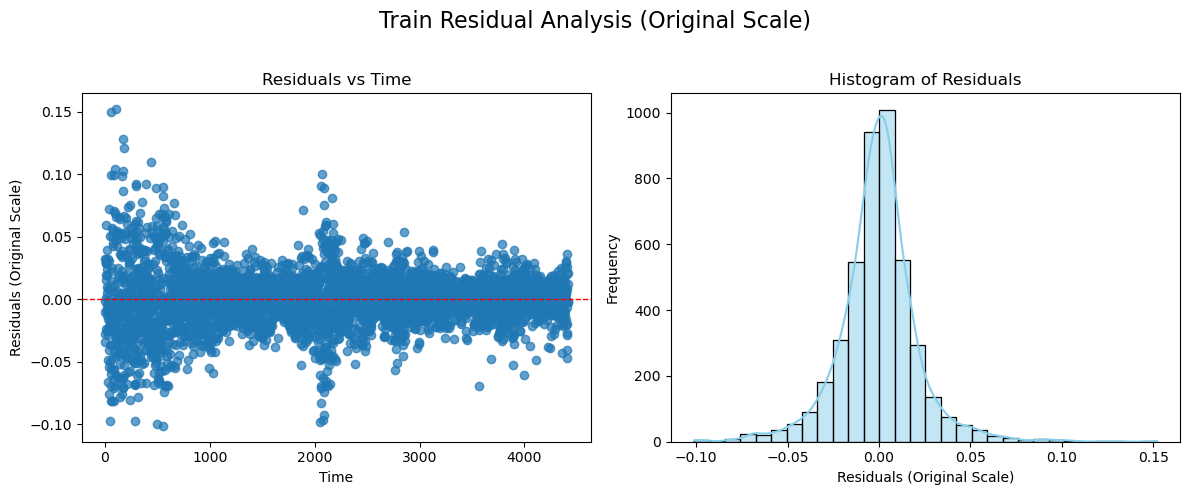

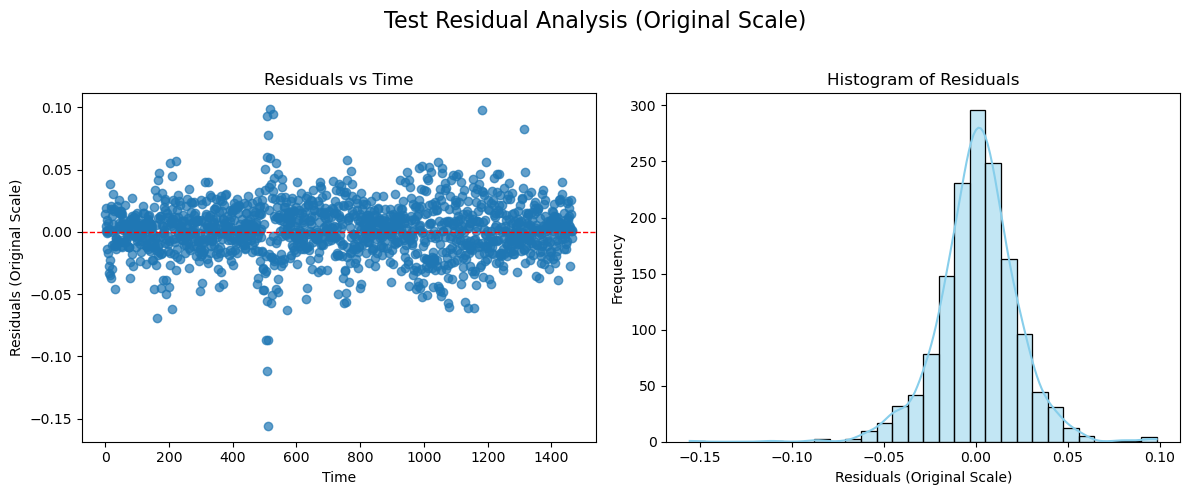

(4426, 13)
(1476, 13)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=-0.002135262579791752, Pred_Close=173.72700904994252
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=-0.002342730431831779, Pred_Close=173.32048986736802
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=-0.002469618578651665, Pred_Close=172.89298247291367
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=-0.002562250546034085, Pred_Close=172.45055438202544
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=-0.0026318791344459485, Pred_Close=171.99728210678884

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.002135
2024-01-02              -0.002343
2024-01-03              -0.002470
2024-01-04              -0.002562
2024-01-05              -0.002632
2024-01-08              -0.002682
2024-01-09              -0.002802
2024-01-10              -0.002831
2024-01-11              -0.002837
2024-01-12              -0.002828
2024-01-15           

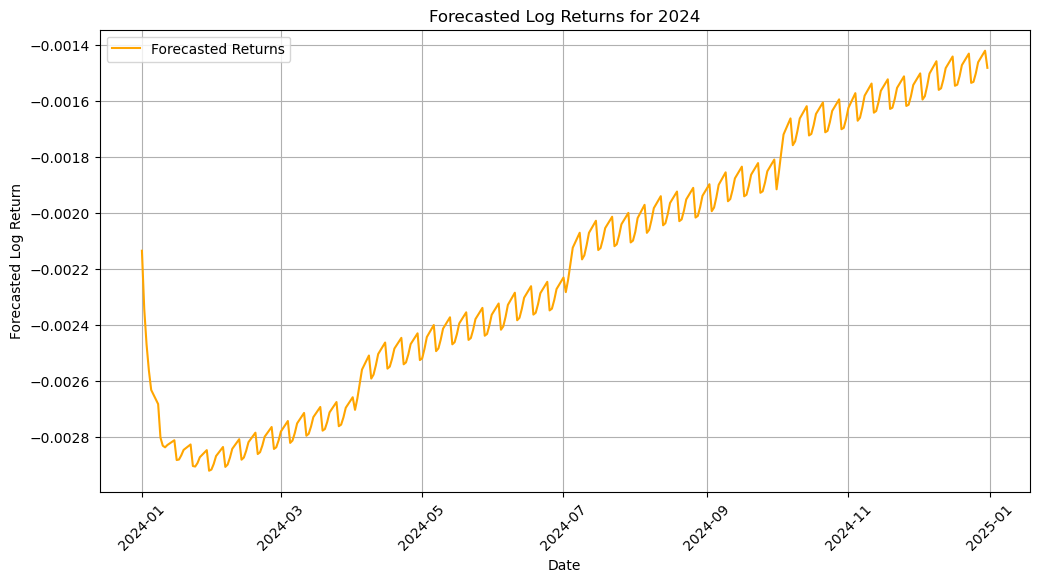

In [15]:
# Execute the workflow for multiple tickers.
tickers1 = ['SMH']
results = run_workflow(tickers1)

Processing SOXX...


[*********************100%***********************]  1 of 1 completed


(4217, 13)
(1406, 13)
Best Model Parameters: OrderedDict([('dropout', 0.34680560359711365), ('learning_rate', 0.00929603444954394), ('units', 48)])
Computation Time: 181.59 seconds
Train RMSE: 0.0199, Train MAE: 0.0142, Train MASE : 0.7010 
Test RMSE: 0.0223, Test MAE: 0.0162, Test MASE: 0.6801 


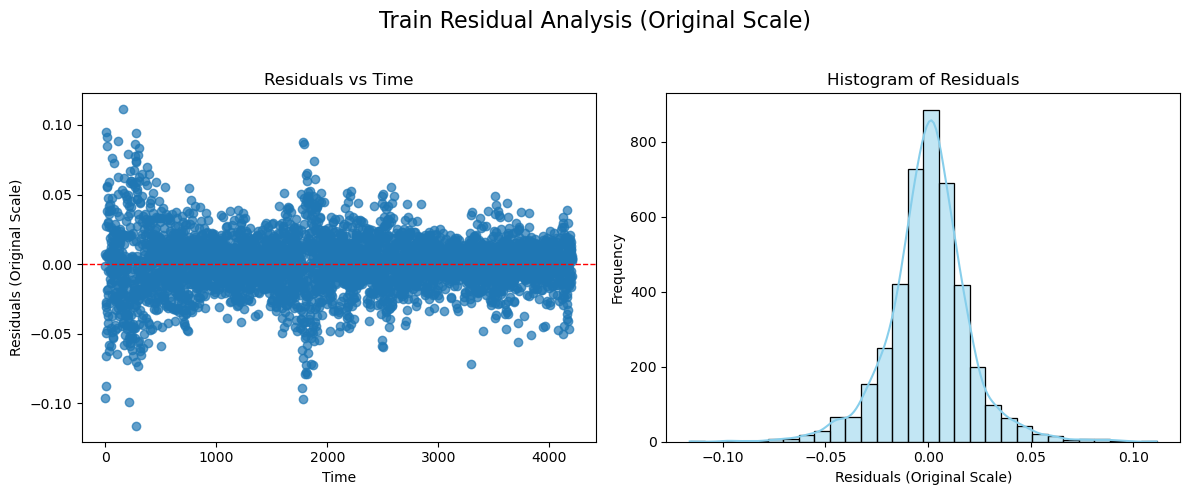

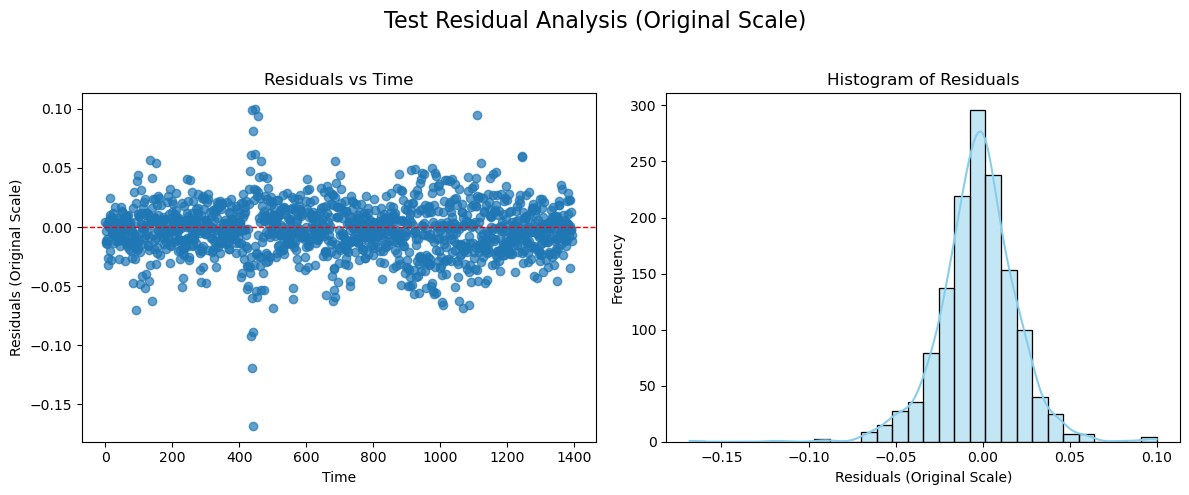

(4217, 13)
(1406, 13)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.0007756391327653355, Pred_Close=190.97495925791273
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.0009519687448811234, Pred_Close=191.1568480126497
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.0006995767042261247, Pred_Close=191.29062367808632
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.0005225980260534687, Pred_Close=191.39061790654046
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.0004009116626002497, Pred_Close=191.46736402054955

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.000776
2024-01-02               0.000952
2024-01-03               0.000700
2024-01-04               0.000523
2024-01-05               0.000401
2024-01-08               0.000315
2024-01-09               0.000349
2024-01-10               0.000264
2024-01-11               0.000195
2024-01-12               0.000146
2024-01-15             

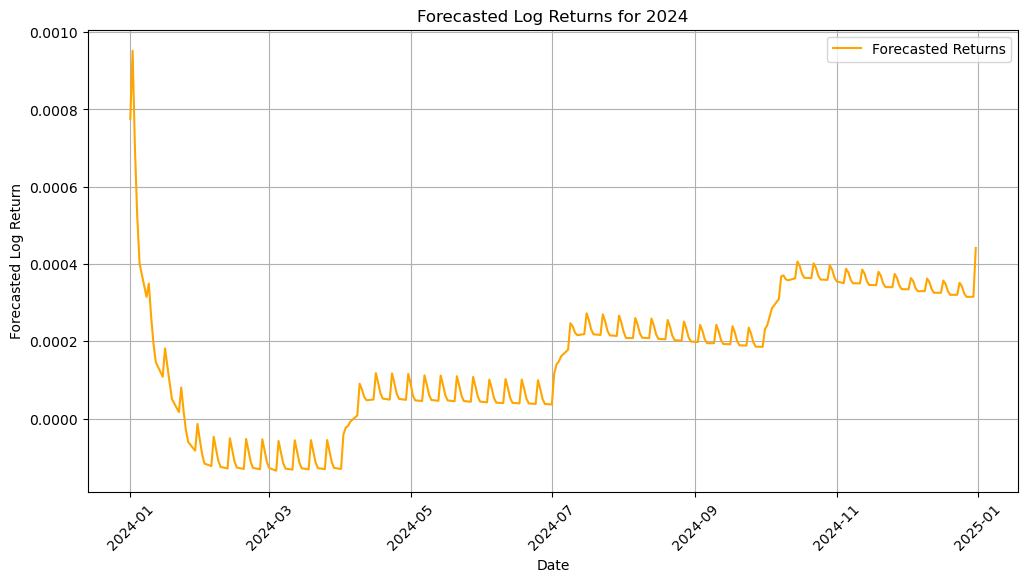

In [16]:
# Execute the workflow for multiple tickers.
tickers2 = ['SOXX']
results = run_workflow(tickers2)

Processing PSI...


[*********************100%***********************]  1 of 1 completed


(3474, 13)
(1159, 13)
Best Model Parameters: OrderedDict([('dropout', 0.3624791976714727), ('learning_rate', 0.0036896845789025456), ('units', 89)])
Computation Time: 167.66 seconds
Train RMSE: 0.0173, Train MAE: 0.0128, Train MASE : 0.6954 
Test RMSE: 0.0238, Test MAE: 0.0175, Test MASE: 0.6764 


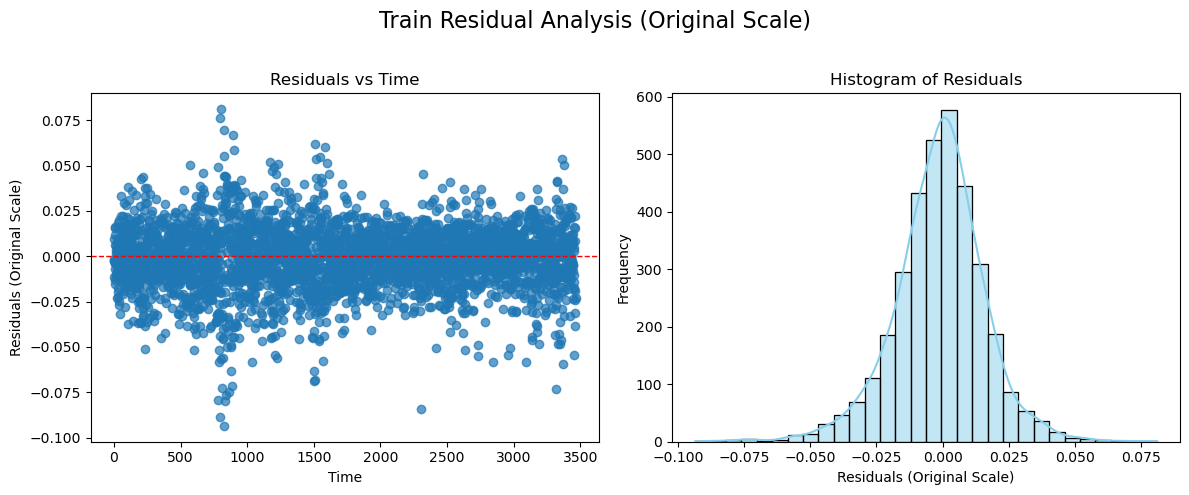

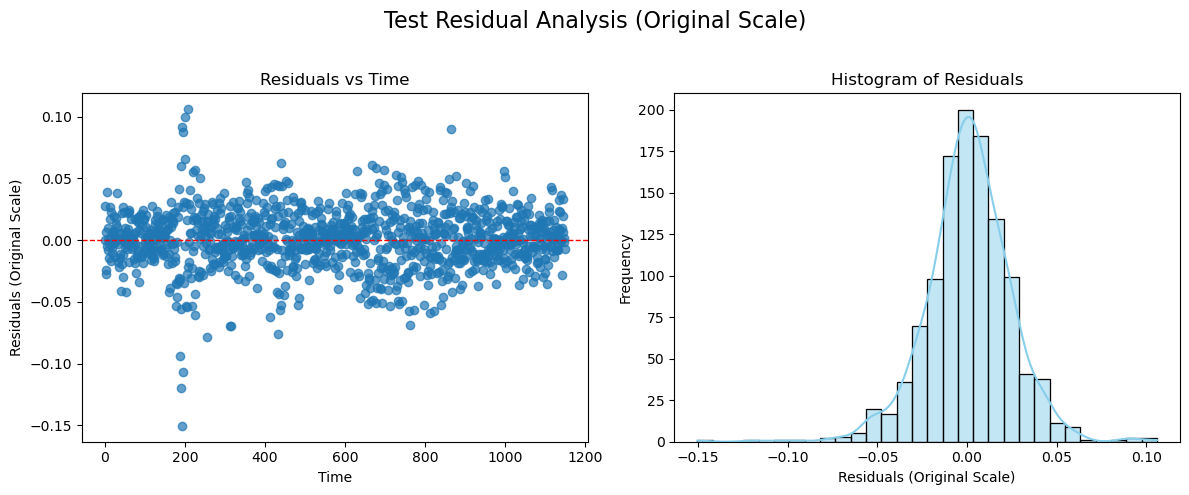

(3474, 13)
(1159, 13)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=-0.00022374795407019104, Pred_Close=49.419712077409955
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=-0.00022199935935957287, Pred_Close=49.40874215069244
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=-0.00036365634752334286, Pred_Close=49.39077761464296
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=-0.0005530145830607027, Pred_Close=49.363471345431805
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=-0.0007139061130412727, Pred_Close=49.32824303782565

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.000224
2024-01-02              -0.000222
2024-01-03              -0.000364
2024-01-04              -0.000553
2024-01-05              -0.000714
2024-01-08              -0.000834
2024-01-09              -0.000769
2024-01-10              -0.000837
2024-01-11              -0.000941
2024-01-12              -0.001029
2024-01-15       

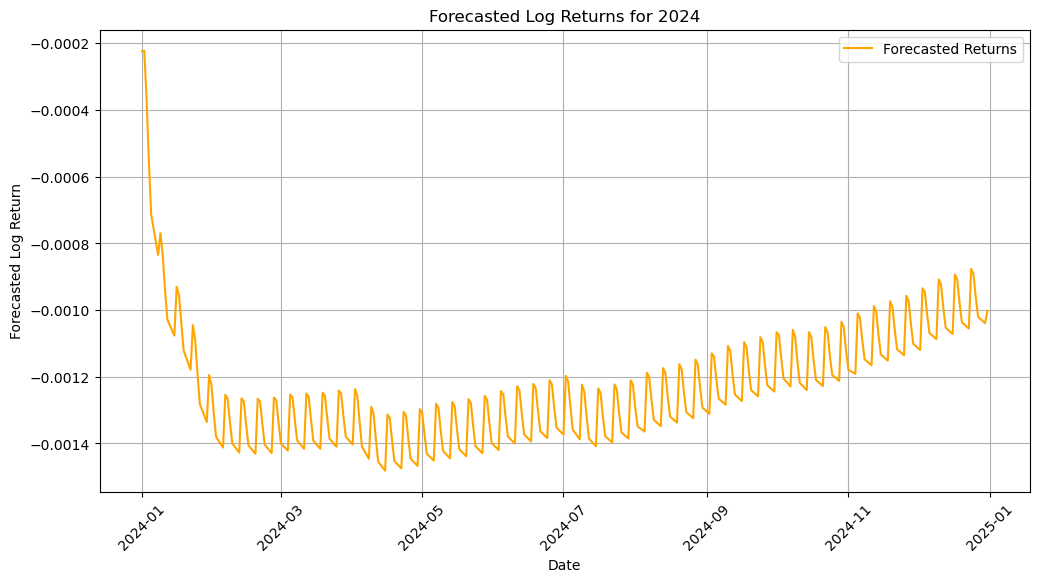

In [17]:
# Execute the workflow for multiple tickers.
tickers3 = ['PSI']
results = run_workflow(tickers3)

Processing XSD...


[*********************100%***********************]  1 of 1 completed


(3357, 13)
(1120, 13)
Best Model Parameters: OrderedDict([('dropout', 0.34680560359711365), ('learning_rate', 0.00929603444954394), ('units', 48)])
Computation Time: 158.00 seconds
Train RMSE: 0.0180, Train MAE: 0.0132, Train MASE : 0.6987 
Test RMSE: 0.0242, Test MAE: 0.0181, Test MASE: 0.6770 


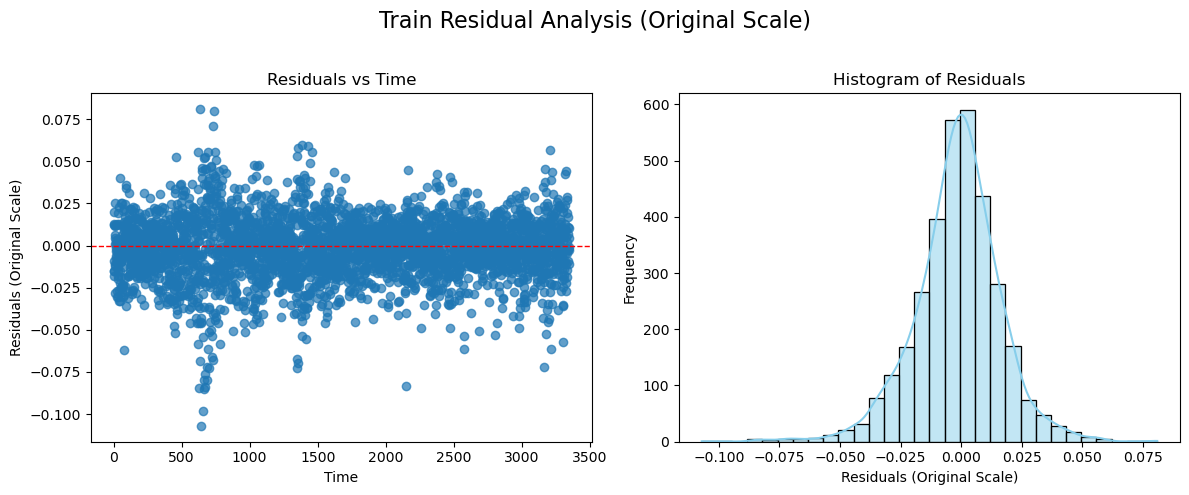

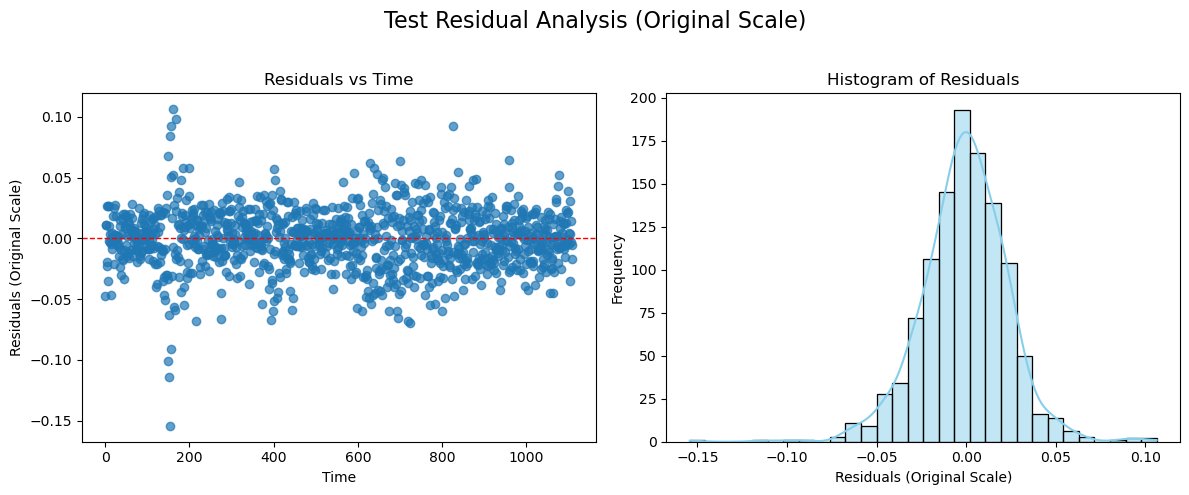

(3357, 13)
(1120, 13)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=-0.0029697140962831976, Pred_Close=223.65902815725116
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=-0.003322177533585729, Pred_Close=222.91722604015135
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=-0.003657916740413362, Pred_Close=222.10330292633242
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=-0.0038212496302690176, Pred_Close=221.25621026916187
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=-0.003850172579422526, Pred_Close=220.4059735048081

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.002970
2024-01-02              -0.003322
2024-01-03              -0.003658
2024-01-04              -0.003821
2024-01-05              -0.003850
2024-01-08              -0.003773
2024-01-09              -0.004122
2024-01-10              -0.004414
2024-01-11              -0.004498
2024-01-12              -0.004434
2024-01-15           

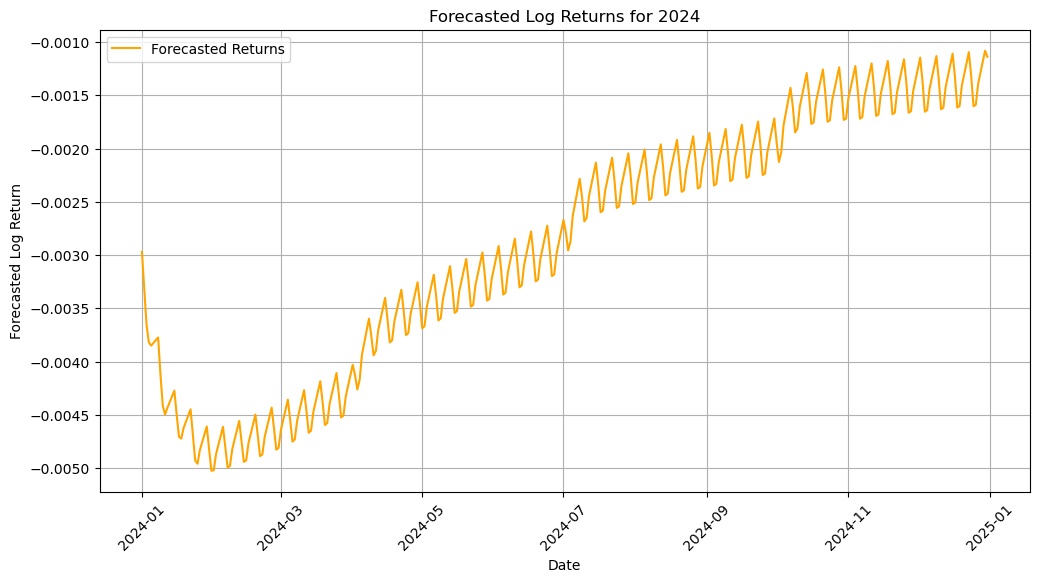

In [18]:
tickers4 = ['XSD']  # Batch 2
results = run_workflow(tickers4)

Processing IYW...


[*********************100%***********************]  1 of 1 completed


(4434, 13)
(1478, 13)
Best Model Parameters: OrderedDict([('dropout', 0.35991068832143464), ('learning_rate', 0.0050834365375292895), ('units', 83)])
Computation Time: 260.86 seconds
Train RMSE: 0.0171, Train MAE: 0.0114, Train MASE : 0.6932 
Test RMSE: 0.0175, Test MAE: 0.0123, Test MASE: 0.6785 


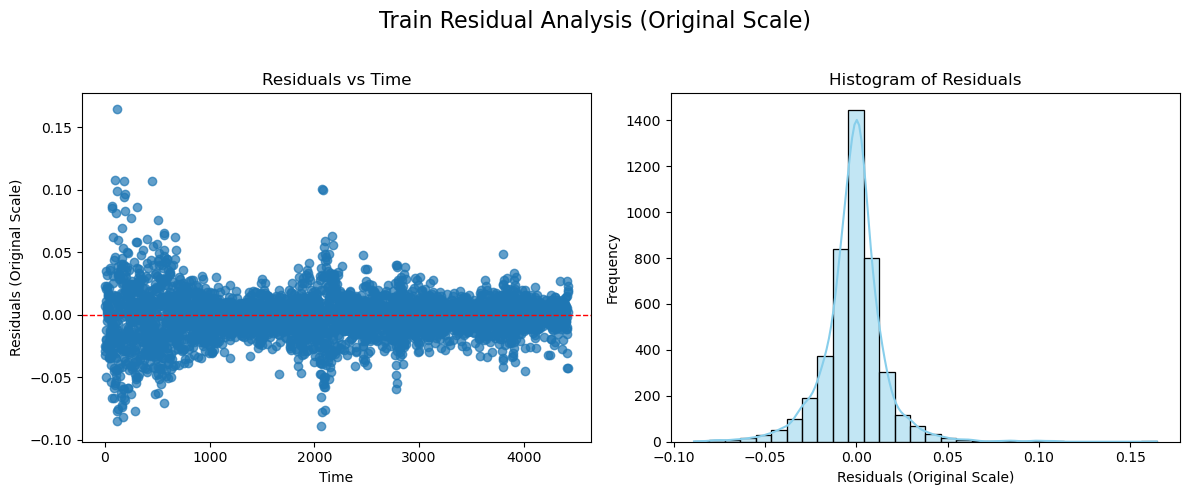

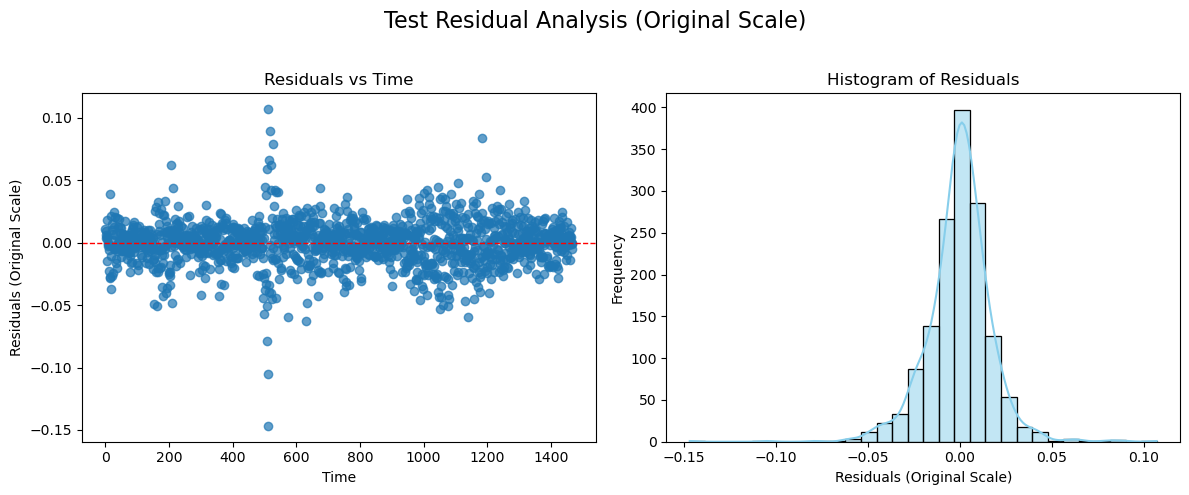

(4434, 13)
(1478, 13)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=-0.0027497118790941397, Pred_Close=122.13820316292421
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=-0.0020401812133096415, Pred_Close=121.88927311295379
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=-0.001704724518035396, Pred_Close=121.68166249032977
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=-0.0014808596194638831, Pred_Close=121.50160238469353
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=-0.001250144234882105, Pred_Close=121.34980276242482

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.002750
2024-01-02              -0.002040
2024-01-03              -0.001705
2024-01-04              -0.001481
2024-01-05              -0.001250
2024-01-08              -0.000965
2024-01-09              -0.001031
2024-01-10              -0.001085
2024-01-11              -0.001109
2024-01-12              -0.001042
2024-01-15         

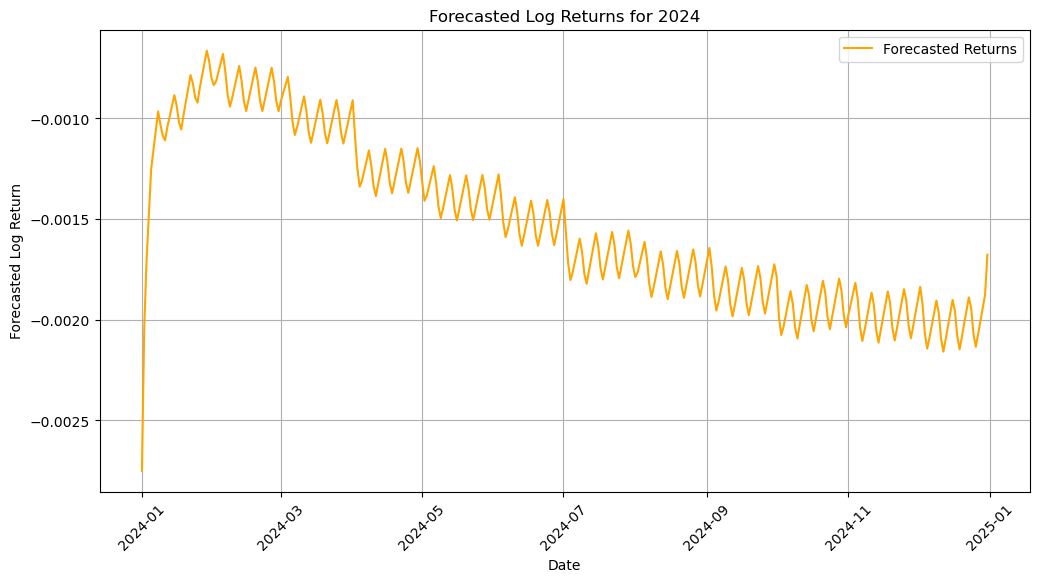

In [19]:
tickers5 = ['IYW']  # Batch 2
results = run_workflow(tickers5)

Processing XLK...


[*********************100%***********************]  1 of 1 completed


(4506, 13)
(1502, 13)
Best Model Parameters: OrderedDict([('dropout', 0.28896650246023037), ('learning_rate', 0.009067795852913275), ('units', 42)])
Computation Time: 224.27 seconds
Train RMSE: 0.0161, Train MAE: 0.0107, Train MASE : 0.6878 
Test RMSE: 0.0170, Test MAE: 0.0119, Test MASE: 0.6826 


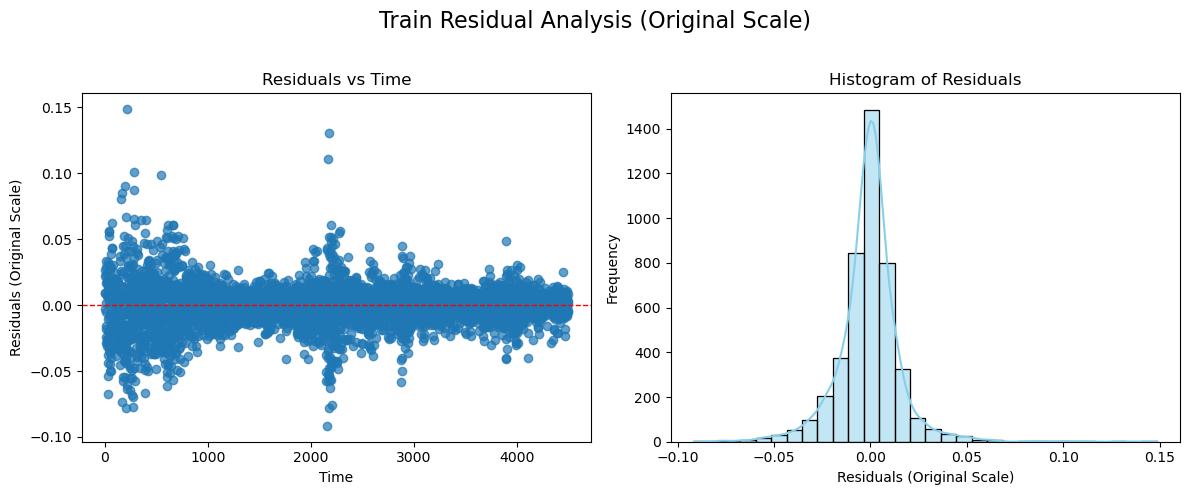

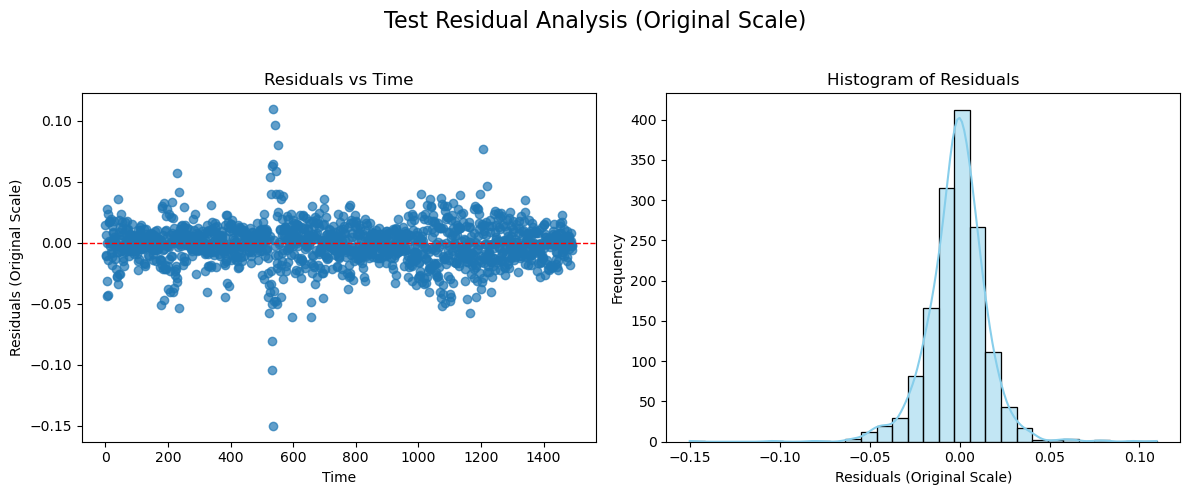

(4506, 13)
(1502, 13)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.0006335134351252907, Pred_Close=191.2901070460979
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.0007095493349852047, Pred_Close=191.42588497921622
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.0007720061193517606, Pred_Close=191.57372399279149
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.0007903307783649028, Pred_Close=191.72519044960623
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.00076440181467548, Pred_Close=191.8718015608658

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.000634
2024-01-02               0.000710
2024-01-03               0.000772
2024-01-04               0.000790
2024-01-05               0.000764
2024-01-08               0.000707
2024-01-09               0.000734
2024-01-10               0.000743
2024-01-11               0.000724
2024-01-12               0.000675
2024-01-15               0

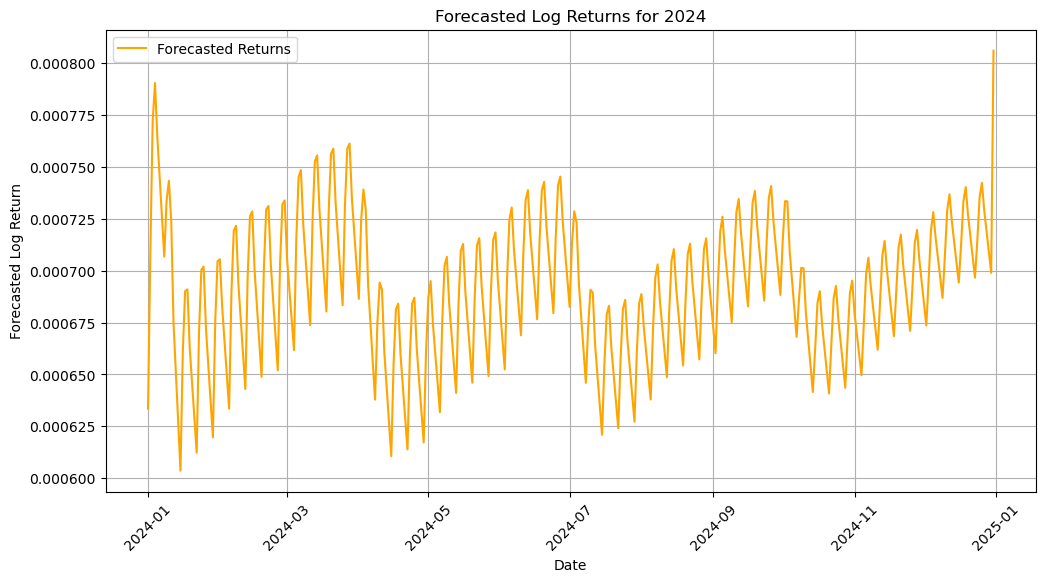

In [20]:
tickers6 = ['XLK']  # Batch 2
results = run_workflow(tickers6)

Processing VGT...


[*********************100%***********************]  1 of 1 completed


(3738, 13)
(1247, 13)
Best Model Parameters: OrderedDict([('dropout', 0.2820207917706628), ('learning_rate', 0.007204993248990244), ('units', 122)])
Computation Time: 242.38 seconds
Train RMSE: 0.0129, Train MAE: 0.0089, Train MASE : 0.6887 
Test RMSE: 0.0175, Test MAE: 0.0125, Test MASE: 0.7000 


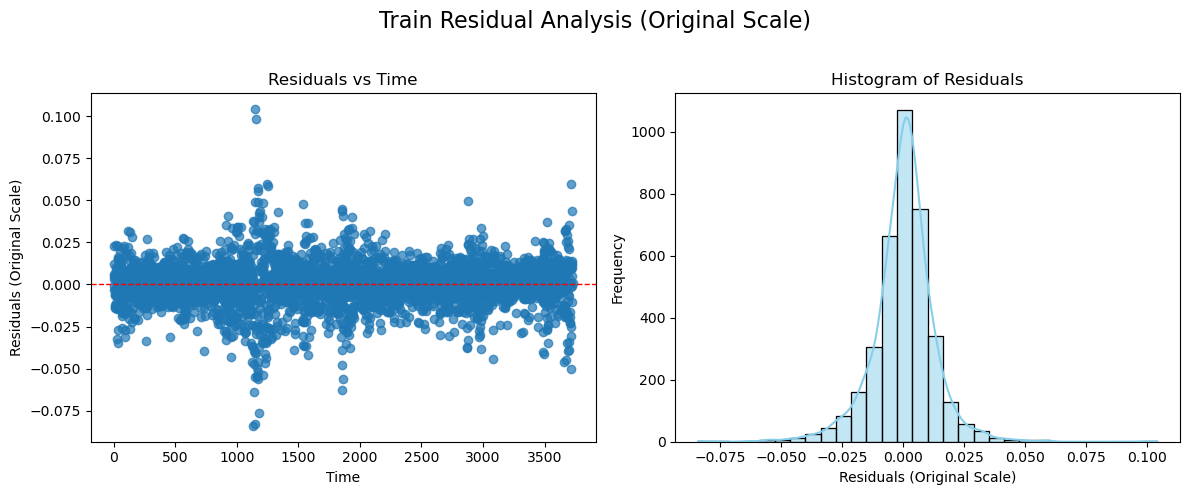

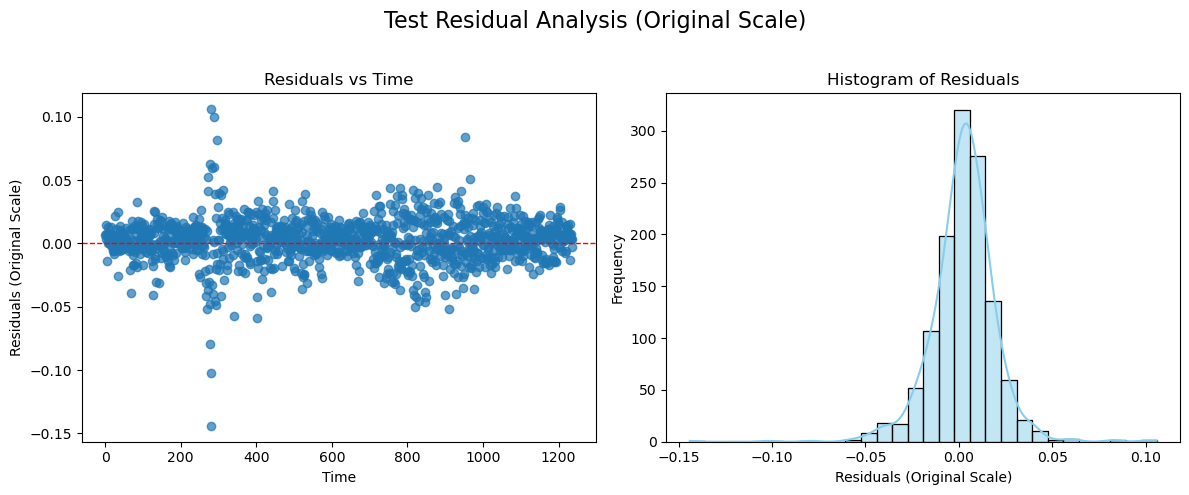

(3738, 13)
(1247, 13)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=-0.0005016164679540003, Pred_Close=480.6391530651698
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=-0.0003799590468427378, Pred_Close=480.4565645609696
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=-0.00048480475126365136, Pred_Close=480.22369338878104
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=-0.0006376288952462282, Pred_Close=479.91758648736834
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=-0.0007530496217234423, Pred_Close=479.5563207729827

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.000502
2024-01-02              -0.000380
2024-01-03              -0.000485
2024-01-04              -0.000638
2024-01-05              -0.000753
2024-01-08              -0.000822
2024-01-09              -0.000649
2024-01-10              -0.000675
2024-01-11              -0.000757
2024-01-12              -0.000827
2024-01-15         

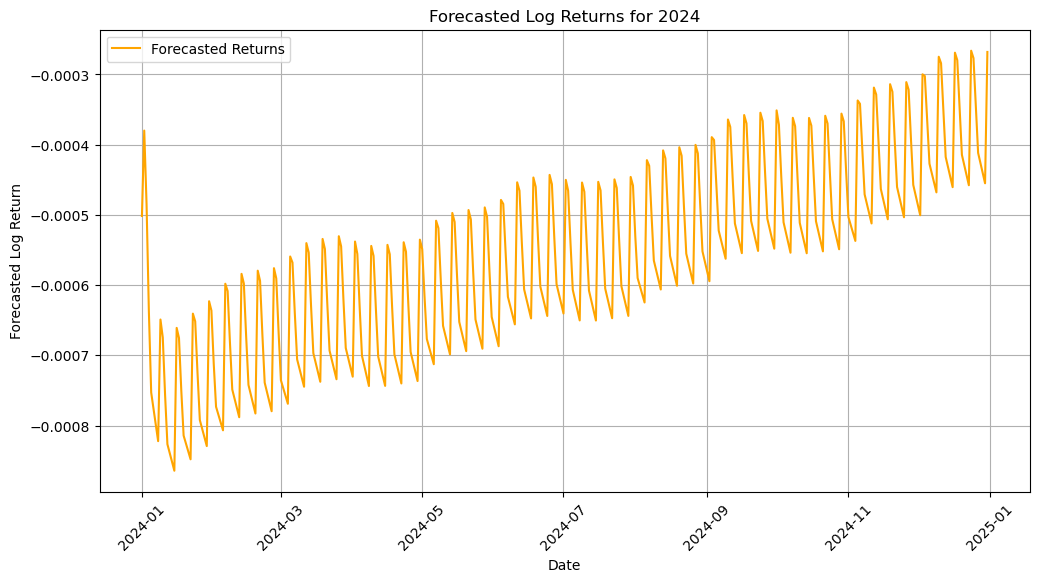

In [21]:
tickers7 = ['VGT']  # Batch 3

results = run_workflow(tickers7)

Processing QQQ...


[*********************100%***********************]  1 of 1 completed


(4506, 13)
(1502, 13)
Best Model Parameters: OrderedDict([('dropout', 0.3674776711106569), ('learning_rate', 0.008689364966720042), ('units', 61)])
Computation Time: 291.30 seconds
Train RMSE: 0.0174, Train MAE: 0.0114, Train MASE : 0.6855 
Test RMSE: 0.0159, Test MAE: 0.0112, Test MASE: 0.6829 


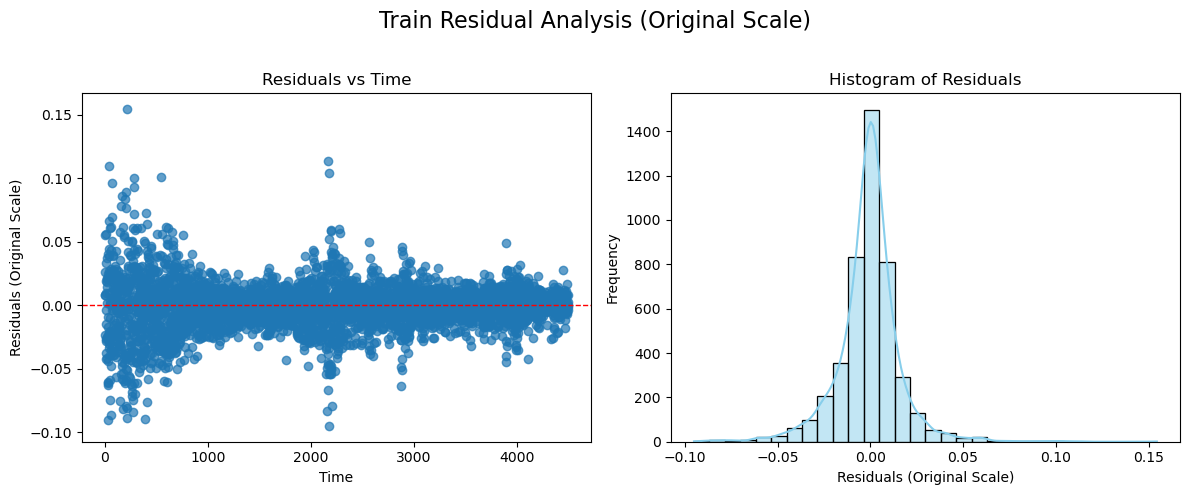

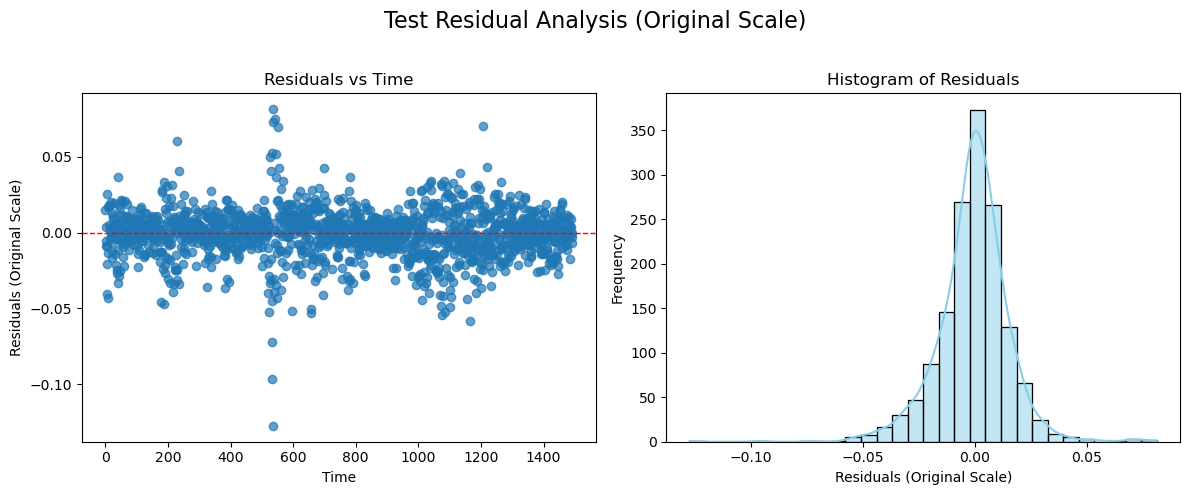

(4506, 13)
(1502, 13)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.00016463098050875072, Pred_Close=407.1677654363416
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.000179025074489982, Pred_Close=407.240665201127
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.00015559006197508478, Pred_Close=407.3040327310155
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.00013966436501857785, Pred_Close=407.36092256276504
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.0001318576508242117, Pred_Close=407.4146397584855

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.000165
2024-01-02               0.000179
2024-01-03               0.000156
2024-01-04               0.000140
2024-01-05               0.000132
2024-01-08               0.000130
2024-01-09               0.000131
2024-01-10               0.000114
2024-01-11               0.000107
2024-01-12               0.000107
2024-01-15               

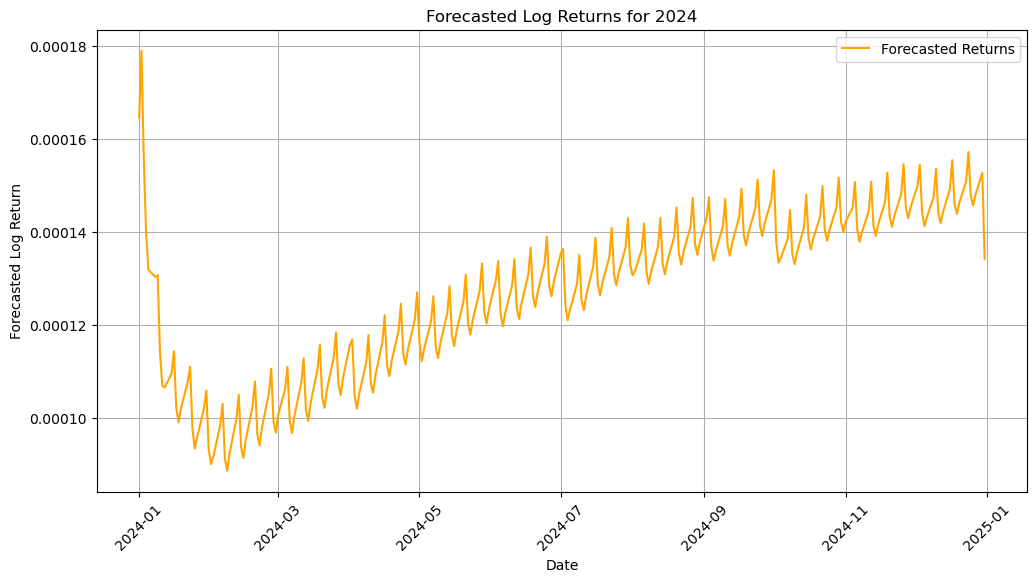

In [22]:
tickers8 = ['QQQ']  # Batch 3

results = run_workflow(tickers8)

Processing IGM...


[*********************100%***********************]  1 of 1 completed


(4278, 13)
(1426, 13)
Best Model Parameters: OrderedDict([('dropout', 0.28896650246023037), ('learning_rate', 0.009067795852913275), ('units', 42)])
Computation Time: 253.82 seconds
Train RMSE: 0.0150, Train MAE: 0.0103, Train MASE : 0.6909 
Test RMSE: 0.0171, Test MAE: 0.0121, Test MASE: 0.6842 


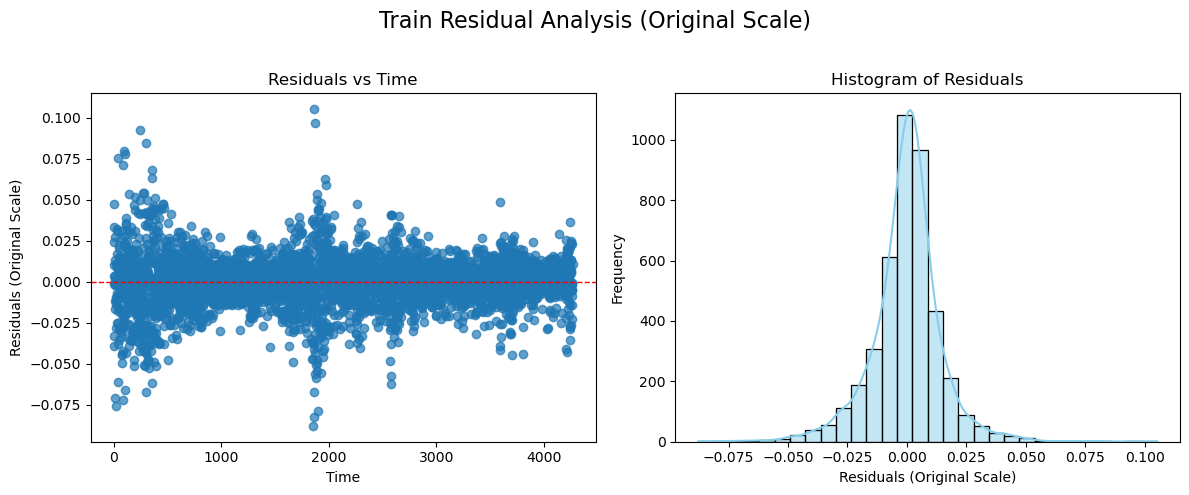

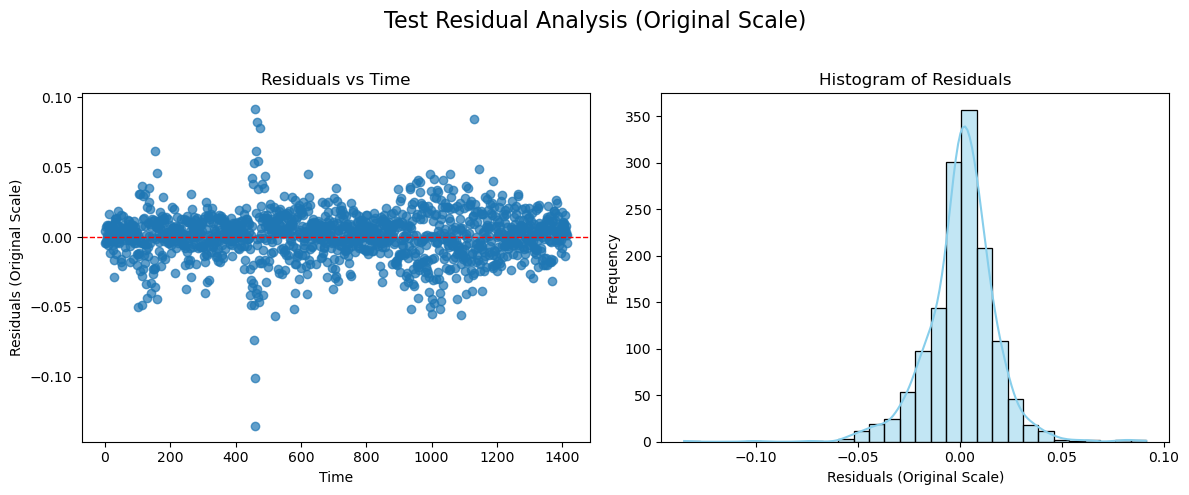

(4278, 13)
(1426, 13)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.002317802328792715, Pred_Close=74.69444136061007
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.0027921036817640053, Pred_Close=74.90328740957389
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.003274088033592213, Pred_Close=75.14892927366927
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.003685514350190966, Pred_Close=75.42640273303988
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.004015773873018704, Pred_Close=75.72990710506446

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.002318
2024-01-02               0.002792
2024-01-03               0.003274
2024-01-04               0.003686
2024-01-05               0.004016
2024-01-08               0.004263
2024-01-09               0.004379
2024-01-10               0.004504
2024-01-11               0.004599
2024-01-12               0.004667
2024-01-15               0.0047

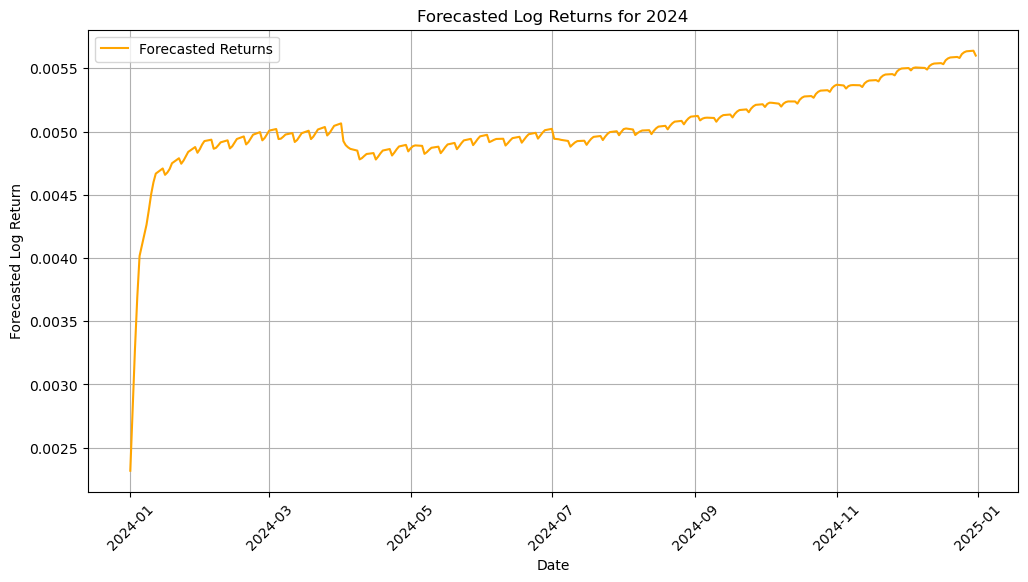

In [23]:
tickers9 = ['IGM']  # Batch 3

results = run_workflow(tickers9)

[*********************100%***********************]  1 of 1 completed

Processing IXN...
(4149, 13)
(1384, 13)


Best Model Parameters: OrderedDict([('dropout', 0.34680560359711365), ('learning_rate', 0.00929603444954394), ('units', 48)])
Computation Time: 288.29 seconds
Train RMSE: 0.0145, Train MAE: 0.0099, Train MASE : 0.7120 
Test RMSE: 0.0173, Test MAE: 0.0121, Test MASE: 0.6856 


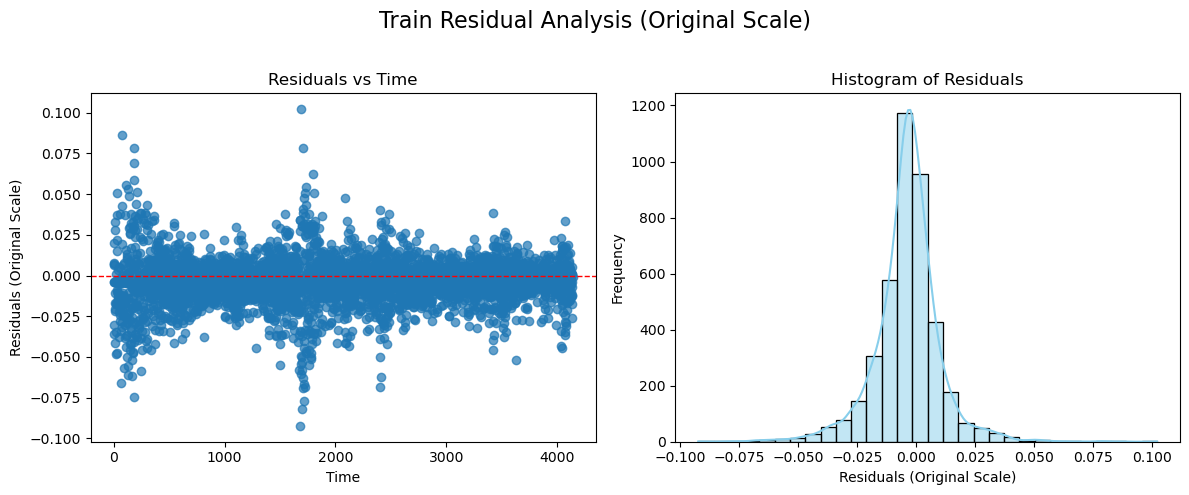

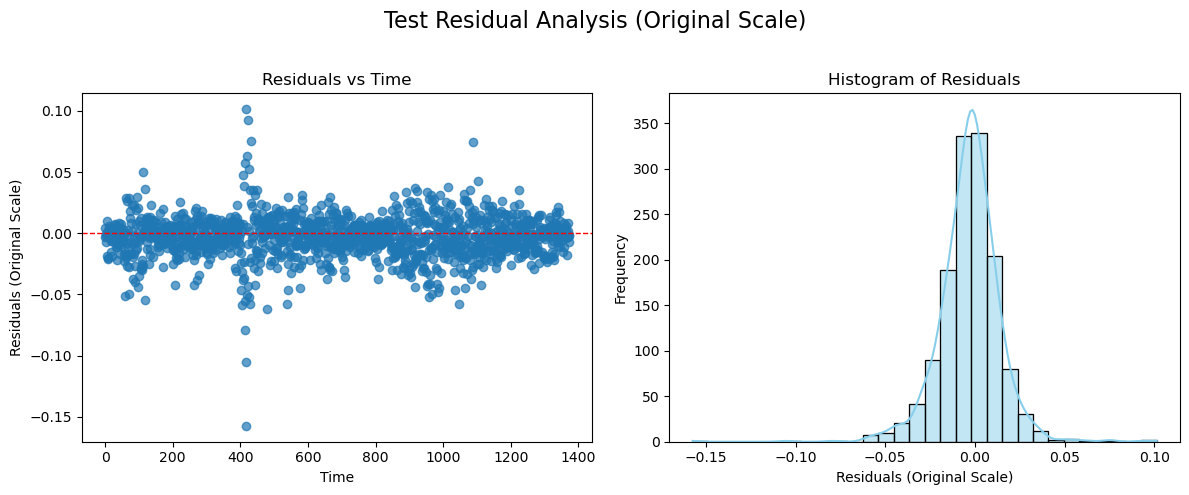

(4149, 13)
(1384, 13)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.0018125125808475147, Pred_Close=68.01008222735314
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.0019067244102611224, Pred_Close=68.1398824185513
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.001963011322569197, Pred_Close=68.27377315077442
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.002005461470719906, Pred_Close=68.41083095842944
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.002053689990820609, Pred_Close=68.55146996225932

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.001813
2024-01-02               0.001907
2024-01-03               0.001963
2024-01-04               0.002005
2024-01-05               0.002054
2024-01-08               0.002108
2024-01-09               0.002129
2024-01-10               0.002141
2024-01-11               0.002147
2024-01-12               0.002161
2024-01-15               0.0021

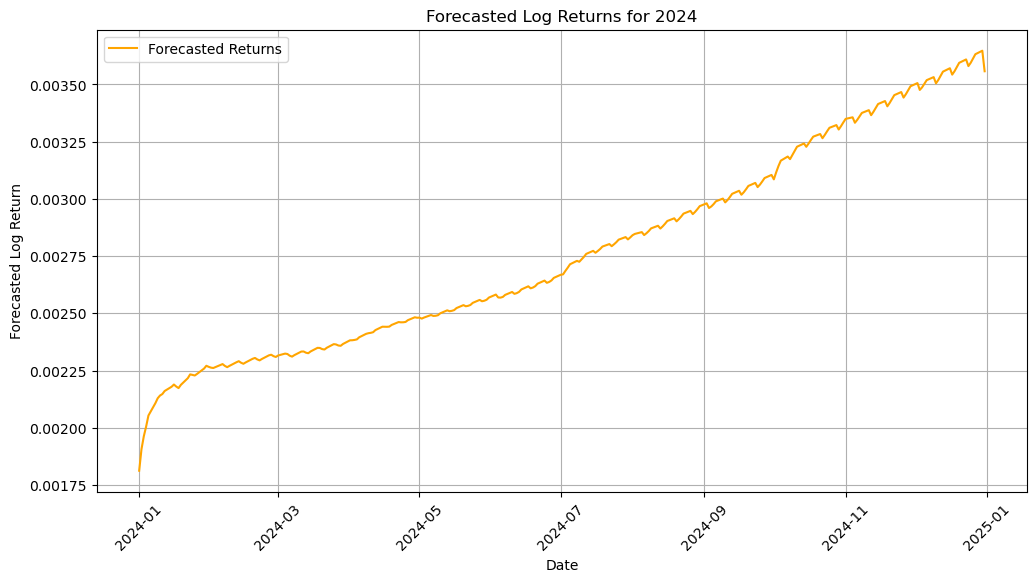

In [25]:
tickers10 = ['IXN']  # Batch 3

results = run_workflow(tickers10)

Overall mean Training MAE: 0.0118
Overall mean Test MAE: 0.0140
Overall mean Training RMSE: 0.0170
Overall mean Test RMSE: 0.0194
Overall mean Training MASE: 0.69%
Overall mean Test MASE: 0.68%
Total time elapsed to run the model: 2256.72 seconds
Average time consumed by model to train on an ETF: 225.67 seconds


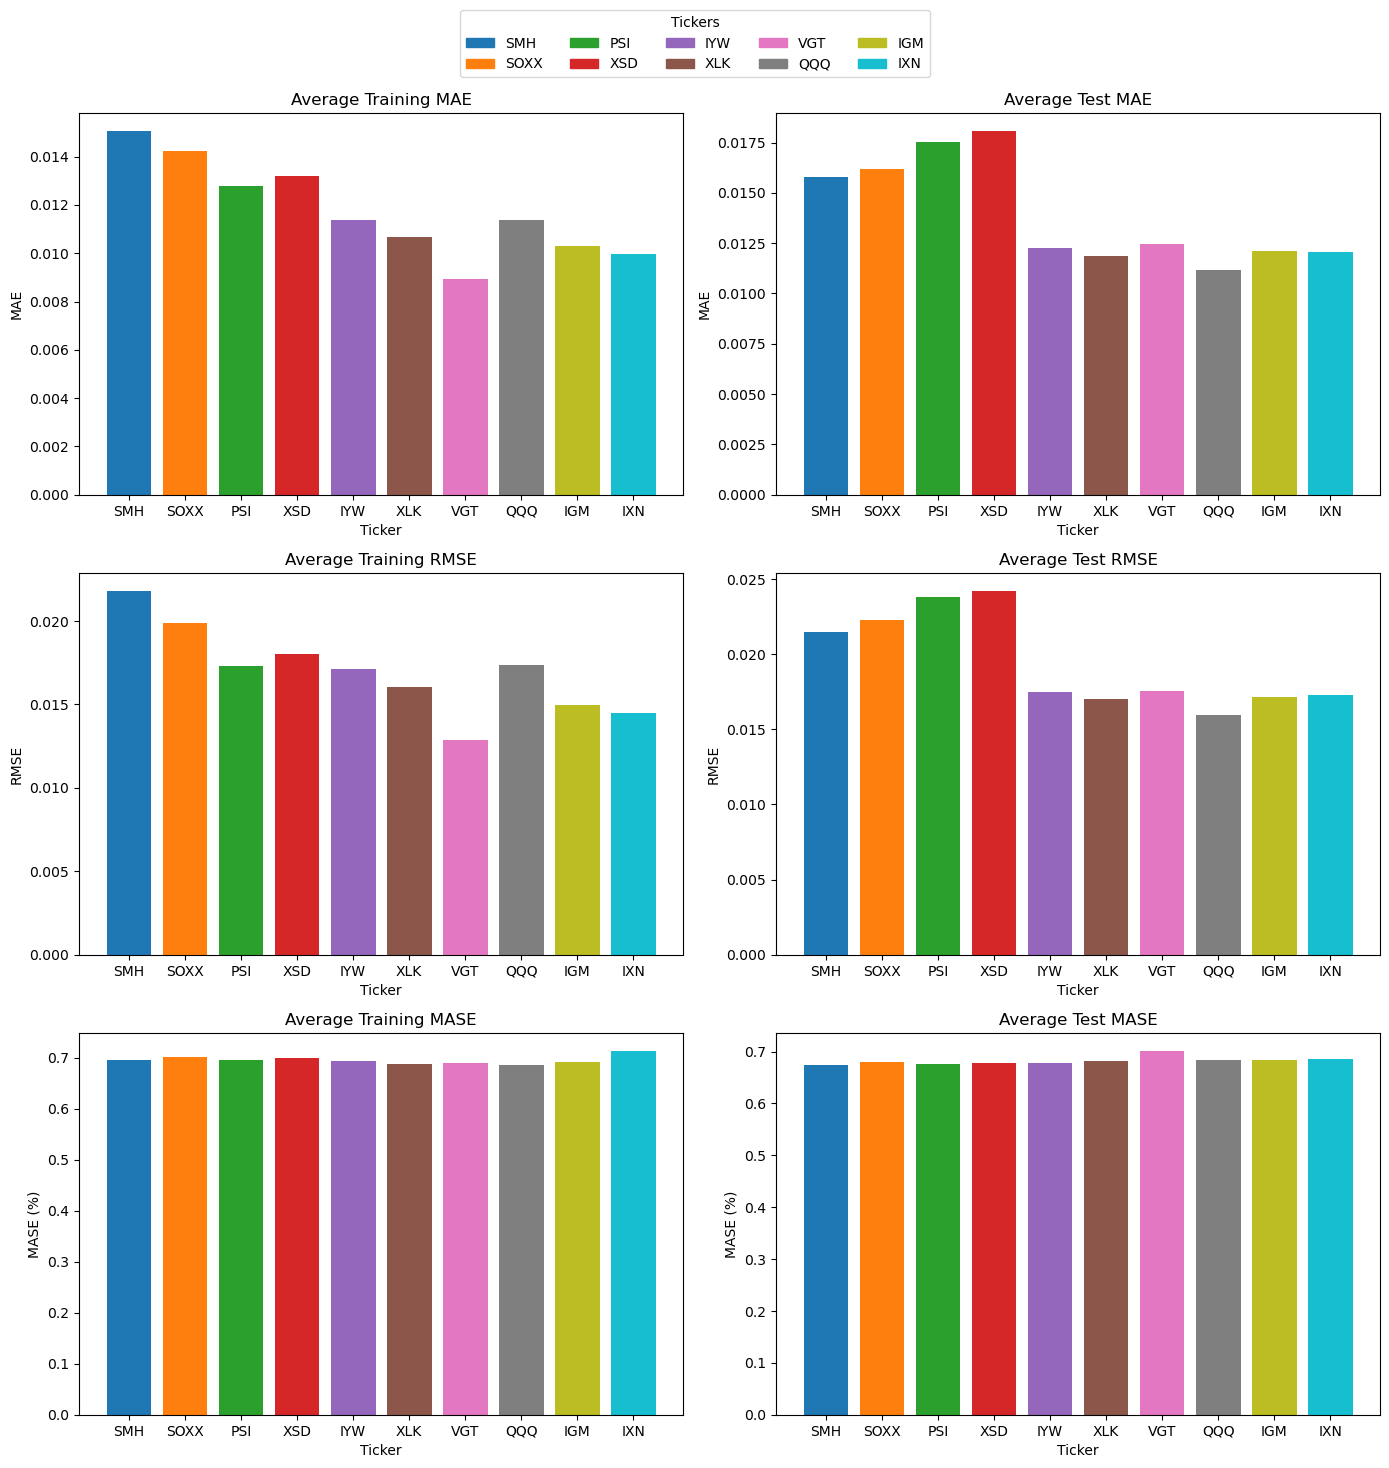

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean

def plot_model_metrics(tickers, results):
    """
    Plots model performance metrics (MAE, RMSE, and MASE) for training and test sets.
    
    Parameters:
    - tickers: List of tickers.
    - results: Dictionary containing model metrics for each ticker.
    """
    
    # --- 1. Gather metrics from 'results' for each ticker ---
    avg_training_mae = []
    avg_test_mae = []
    avg_training_rmse = []
    avg_test_rmse = []
    avg_training_mase = []
    avg_test_mase = []

    computation_time = []
    
    for ticker in tickers:
        model_metrics = results[ticker].get("model_metrics", {})
        
        train_set = model_metrics.get("training_set", {})
        test_set = model_metrics.get("test_set", {})
        
        avg_training_mae.append(train_set.get("mae", float('nan')))
        avg_test_mae.append(test_set.get("mae", float('nan')))
        avg_training_rmse.append(train_set.get("rmse", float('nan')))
        avg_test_rmse.append(test_set.get("rmse", float('nan')))
        avg_training_mase.append(train_set.get("mase", float('nan')))
        avg_test_mase.append(test_set.get("mase", float('nan')))

        computation_time.append(model_metrics.get("time", float('nan'))) 
    
    # Print global averages
    print(f"Overall mean Training MAE: {mean(avg_training_mae):.4f}")
    print(f"Overall mean Test MAE: {mean(avg_test_mae):.4f}")
    print(f"Overall mean Training RMSE: {mean(avg_training_rmse):.4f}")
    print(f"Overall mean Test RMSE: {mean(avg_test_rmse):.4f}")
    print(f"Overall mean Training MASE: {mean(avg_training_mase):.2f}")
    print(f"Overall mean Test MASE: {mean(avg_test_mase):.2f}")
    print(f"Total time elapsed to run the model: {sum(computation_time):.2f} seconds")
    print(f"Average time consumed by model to train on an ETF: {mean(computation_time):.2f} seconds")

    # --- 2. Define a color palette ---
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]

    # --- 3. Set up a 3×2 subplot grid ---
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))
    x_positions = range(len(tickers))  # One position per ticker

    # --- Subplot 1: Average Training MAE ---
    ax = axs[0, 0]
    ax.bar(x_positions, avg_training_mae, color=colors[:len(tickers)])
    ax.set_title("Average Training MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 2: Average Test MAE ---
    ax = axs[0, 1]
    ax.bar(x_positions, avg_test_mae, color=colors[:len(tickers)])
    ax.set_title("Average Test MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 3: Average Training RMSE ---
    ax = axs[1, 0]
    ax.bar(x_positions, avg_training_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Training RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 4: Average Test RMSE ---
    ax = axs[1, 1]
    ax.bar(x_positions, avg_test_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Test RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 5: Average Training MASE ---
    ax = axs[2, 0]
    ax.bar(x_positions, avg_training_mase, color=colors[:len(tickers)])
    ax.set_title("Average Training MASE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MASE (%)")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 6: Average Test MASE ---
    ax = axs[2, 1]
    ax.bar(x_positions, avg_test_mase, color=colors[:len(tickers)])
    ax.set_title("Average Test MASE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MASE (%)")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- 4. Create a single legend for the entire figure ---
    legend_handles = [
        mpatches.Patch(color=c, label=ticker)
        for c, ticker in zip(colors[:len(tickers)], tickers)
    ]
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    fig.legend(
        handles=legend_handles,
        title="Tickers",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(tickers))
    )

    plt.show()

tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']

plot_model_metrics(tickers, results)

In [27]:
def calculate_sharpe_ratio(returns, annual_risk_free_rate=0.1,period='daily'):
    #excess_returns = rate_of_return(returns) - risk_free_rate
    
    # Convert annual risk-free rate to daily rate
    daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1
    
    # Calculate mean daily log return
    mean_return = np.mean(returns)
    
    # Calculate excess daily log return
    excess_return = mean_return - daily_risk_free_rate
    
    # Calculate standard deviation of daily log returns
    std_return = np.std(returns)
    
    # Print diagnostic information
    #print(f"Mean Daily Log Return: {mean_return}")
    #print(f"Excess Daily Log Return: {excess_return}")
    #print(f"Standard Deviation of Daily Log Returns: {std_return}")
    epsilon = 0
    # Check for zero standard deviation to avoid division by zero
    if std_return == 0:
        epsilon = 1e-5 
    
    # Calculate Sharpe ratio
    #sharpe_ratio = (excess_return / std_return) * np.sqrt(252)  # Annualize the Sharpe ratio
    sharpe_ratio = (excess_return / (std_return +  epsilon)) # Annualize the Sharpe ratio

    return sharpe_ratio
    #return excess_returns / np.std(returns)


def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES)
    es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    
    # Step 4: Calculate Expected Gain (EG)
    eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    
    # Step 5: Compute the Rachev Ratio
    rachev_ratio = eg / -es
    return rachev_ratio


"""def calculate_volatility_clustering(returns):
    squared_returns = returns ** 2
    n = len(squared_returns)
    
    # Mean of squared returns
    mean_squared_returns = np.mean(squared_returns)
    
    # Calculate the numerator and denominator for autocorrelation at lag 1
    numerator = np.sum((squared_returns[:-1] - mean_squared_returns) * (squared_returns[1:] - mean_squared_returns))
    denominator = np.sum((squared_returns - mean_squared_returns) ** 2)
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    rho_1 = numerator / denominator
    return rho_1"""
def calculate_volatility_clustering(returns):
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    squared_returns = returns ** 2
    n = len(squared_returns)

    # Mean of squared returns
    mean_squared = np.mean(squared_returns)
    clustering = np.sum((squared_returns - mean_squared) ** 2) / (n - 1 if n > 1 else 1)
    return clustering

def calculate_sortino_ratio(log_returns, target_log_return=0.04):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )
    
    # Calculate Sortino Ratio
    #sortino_ratio_value = (avg_log_return - target_log_return) / downside_deviation
    epsilon = 1e-8
    
    # Add epsilon to downside_deviation to prevent division by zero
    #if downside_deviation == 0:
     #   return np.nan  # Return NaN if downside deviation is zero
    
    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        for month in range(1, 13):
            future_predictions = data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            risk_metrics_results[ticker][f'risk_metrics_{month}m'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
            #print(risk_metrics_results)
    return risk_metrics_results


In [28]:
def calculate_composite_score(
    forecasted_values, risk_percentage, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    epsilon = 1e-8  # To prevent division by zero
    forecasted_mean = np.mean(forecasted_values)

    # Normalize the components with epsilon
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / (std_forecast + epsilon)
    rachev_normalized = (rachev_ratio - mean_rachev) / (std_rachev + epsilon)
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / (std_sharpe + epsilon)
    sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / (std_volatility_clustering + epsilon)

    # Composite score calculation
    score = (
        forecasted_mean_normalized
        - (risk_percentage * rachev_normalized)
        + sharpe_normalized
        + sortino_normalized
        - volatility_clustering_normalized
    )

    return score

"""def compute_composite_scores(results, risk_metrics_results, risk_percentage):
    composite_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            composite_scores.setdefault(ticker, {})[f'composite_score_{month}m'] = calculate_composite_score(
                forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
    
    return composite_scores"""

def compute_composite_scores(results, risk_metrics_results, risk_percentages):
    composite_scores = {}
    aggregated_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            composite_scores.setdefault(ticker, {})[f'composite_scores_{month}m'] = {}
            
            for risk_percentage in risk_percentages:
                score = calculate_composite_score(
                    forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                    risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                    np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
                )
                composite_scores[ticker][f'composite_scores_{month}m'][risk_percentage] = score
        
        # Compute aggregated scores per ETF per month
        for ticker in composite_scores:
            aggregated_scores.setdefault(ticker, {})[f'aggregated_score_{month}m'] = np.mean(
                list(composite_scores[ticker][f'composite_scores_{month}m'].values())
            )
    print(composite_scores)
    #return composite_scores, aggregated_scores
    return aggregated_scores

In [29]:
#risk_metrics_results2 = compute_risk_metrics(results2)
#compute_composite_scores(results2, risk_metrics_results2, 0.1)

In [30]:
def select_top_etfs_monthly(df, month_label, return_scores=False):
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        return list(df_sorted.itertuples(index=False, name=None))  # Returns tuples (ETF, Score)
    return list(df_sorted['ETF'])  # Returns only ETF names

def generate_month_ranges(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    month_ranges = []
    while start < end:
        month_start = start
        month_end = (start + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        month_ranges.append((month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')))
        start = month_end + timedelta(days=1)
    return month_ranges

def gather_etf_data(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = f"{start_date} to {end_date}"
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            etf_data.columns = etf_data.columns.get_level_values(0)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = month.split(" to ")[0]
    for ticker in top_etfs:
        etf_history = etf_histories.get(month, {}).get(ticker)
        if etf_history is not None:
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {month}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_month, curr_month, ticker_shares, etf_histories):
    print(f"Top 2 ETFs for {prev_month}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_month}: {curr_top_etfs}")
    etf_histories_curr = etf_histories.get(curr_month, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs
    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr:
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")
    print(f"Updated ticker shares after {curr_month}: {ticker_shares}")
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}

'''def portfolio(results, risk_percentage=0.2):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m'
        ) for month in range(1, 13)
    }
    return portfolios'''

'''def portfolio(results, risk_percentage=0.1, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m',
            return_scores=return_scores
        ) for month in range(1, 13)
    }
    return portfolios
'''



"def portfolio(results, risk_percentage=0.1, return_scores=False):\n    risk_metrics_results = compute_risk_metrics(results)\n    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)\n    \n    portfolios = {\n        str(month): select_top_etfs_monthly(\n            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),\n            f'{month}m',\n            return_scores=return_scores\n        ) for month in range(1, 13)\n    }\n    return portfolios\n"

In [31]:

def calculate_smoothing(scores_dict, alpha=0.1):
    smoothed_scores = {}
    previous_values = {}
    sorted_months = sorted(scores_dict.keys(), key=lambda m: int(m))
    for month in sorted_months:
        smoothed_scores[month] = {}
        for etf, raw_score in scores_dict[month].items():
            if etf not in previous_values:
                smoothed_value = float(raw_score)
            else:
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[month][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    return smoothed_scores

def portfolio(results, risk_percentages, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentages)
    
    # Store all ETF scores per month instead of only top 2 ETFs
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'aggregated_score_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month


def portfolio_optimization(results, risk_percentages, smoothing=False):
    all_scores = portfolio(results, risk_percentages, return_scores=True)
    print("\n--- Raw Scores Before Smoothing ---")
    for month, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {scores}")
    
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for month, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Month {month}: {scores}")
        
        # Use smoothed scores to select top 2 ETFs per month
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores if no smoothing
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for month, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {etfs}")
    
    month_ranges = generate_month_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data(results.keys(), month_ranges)
    ticker_shares = {}
    ticker_shares_per_month = {}
    
    for i, month_range in enumerate(etf_histories.keys()):
        month_index = str(i + 1)
        top_etfs = portfolios.get(month_index, [])
        if not top_etfs:
            print(f"Warning: No ETFs selected for {month_range}. Skipping trading.")
            continue
        if i == 0:
            ticker_shares = initialize_shares(top_etfs, etf_histories, month_range)
        else:
            prev_month_index = str(i)
            prev_top_etfs = portfolios.get(prev_month_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                month_range,
                ticker_shares,
                etf_histories
            )
        ticker_shares_per_month[month_range] = ticker_shares.copy()
    
    first_trading_day_13m = '2025-01-01'
    month_12_range = list(ticker_shares_per_month.keys())[-1]
    month_13_start = first_trading_day_13m
    month_13_end = '2025-01-06'
    etf_values_13m = {}
    
    if month_12_range in ticker_shares_per_month:
        ticker_shares_12m = ticker_shares_per_month[month_12_range]
        for ticker, shares in ticker_shares_12m.items():
            data = yf.download(ticker, start=month_13_start, end=month_13_end)
            data.columns = data.columns.get_level_values(0)

            if not data.empty:
                closing_price_13m = data['Close'].iloc[0]
                total_value = shares * closing_price_13m
                etf_values_13m[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_13m.values()) if etf_values_13m else 0
    return ticker_shares_per_month, total_portfolio_value


In [32]:

portfolios, final_value = portfolio_optimization(results, risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1m': {0.01: -3.106332357192519, 0.04: -3.097878174845844, 0.1: -3.080969810152494, 0.2: -3.0527892023302448}, 'composite_scores_2m': {0.01: -2.9387087263254212, 0.04: -2.931217352107203, 0.1: -2.916234603670768, 0.2: -2.891263356276707}, 'composite_scores_3m': {0.01: -2.836707346626961, 0.04: -2.8287561130437164, 0.1: -2.812853645877228, 0.2: -2.786349533933081}, 'composite_scores_4m': {0.01: -2.4570286368048486, 0.04: -2.4487322035321513, 0.1: -2.4321393369867574, 0.2: -2.4044845594111006}, 'composite_scores_5m': {0.01: -2.5569438925815464, 0.04: -2.5671388564418702, 0.1: -2.5875287841625174, 0.2: -2.6215119970302627}, 'composite_scores_6m': {0.01: -2.5008407596815916, 0.04: -2.510530373519158, 0.1: -2.529909601194291, 0.2: -2.562208313986179}, 'composite_scores_7m': {0.01: -2.105936152074056, 0.04: -2.1173292016617293, 0.1: -2.140115300837076, 0.2: -2.1780921327959875}, 'composite_scores_8m': {0.01: -2.44991031040875, 0.04: -2.456388333422467, 0.1: -2.46934

[*********************100%***********************]  1 of 1 completed

Buy IGM: 687.41 shares at 72.55.
Buy IXN: 755.40 shares at 66.02.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['IGM', 'IXN']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['IGM', 'IXN']
Updated ticker shares after 2024-02-01 to 2024-02-29: {'IGM': 687.4146806398161, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['IGM', 'IXN']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['IGM', 'IXN']
Updated ticker shares after 2024-03-01 to 2024-03-31: {'IGM': 687.4146806398161, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['IGM', 'IXN']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IGM', 'IXN']
Updated ticker shares after 2024-04-01 to 2024-04-30: {'IGM': 687.4146806398161, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IGM', 'IXN']
Top 2 ETFs for 2024-05-01 to 2024-05-31: ['IGM', 'IXN']
Updated ticker shares after 2024-05-01 to 2024-05-31: {'IGM': 687.4146806398161, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-05-01 to 2024-05-31: ['IGM', 'IXN']
To


[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: 134133.55


In [33]:

portfolios, final_value = portfolio_optimization(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1m': {0.01: -3.106332357192519, 0.04: -3.097878174845844, 0.1: -3.080969810152494, 0.2: -3.0527892023302448}, 'composite_scores_2m': {0.01: -2.9387087263254212, 0.04: -2.931217352107203, 0.1: -2.916234603670768, 0.2: -2.891263356276707}, 'composite_scores_3m': {0.01: -2.836707346626961, 0.04: -2.8287561130437164, 0.1: -2.812853645877228, 0.2: -2.786349533933081}, 'composite_scores_4m': {0.01: -2.4570286368048486, 0.04: -2.4487322035321513, 0.1: -2.4321393369867574, 0.2: -2.4044845594111006}, 'composite_scores_5m': {0.01: -2.5569438925815464, 0.04: -2.5671388564418702, 0.1: -2.5875287841625174, 0.2: -2.6215119970302627}, 'composite_scores_6m': {0.01: -2.5008407596815916, 0.04: -2.510530373519158, 0.1: -2.529909601194291, 0.2: -2.562208313986179}, 'composite_scores_7m': {0.01: -2.105936152074056, 0.04: -2.1173292016617293, 0.1: -2.140115300837076, 0.2: -2.1780921327959875}, 'composite_scores_8m': {0.01: -2.44991031040875, 0.04: -2.456388333422467, 0.1: -2.46934

[*********************100%***********************]  1 of 1 completed

Buy IGM: 687.41 shares at 72.55.
Buy IXN: 755.40 shares at 66.02.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['IGM', 'IXN']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['IGM', 'IXN']
Updated ticker shares after 2024-02-01 to 2024-02-29: {'IGM': 687.414608355392, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['IGM', 'IXN']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['IGM', 'IXN']
Updated ticker shares after 2024-03-01 to 2024-03-31: {'IGM': 687.414608355392, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['IGM', 'IXN']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IGM', 'IXN']
Updated ticker shares after 2024-04-01 to 2024-04-30: {'IGM': 687.414608355392, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IGM', 'IXN']
Top 2 ETFs for 2024-05-01 to 2024-05-31: ['IGM', 'IXN']
Updated ticker shares after 2024-05-01 to 2024-05-31: {'IGM': 687.414608355392, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-05-01 to 2024-05-31: ['IGM', 'IXN']
Top 2 


[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: 134133.55


In [34]:
import numpy as np

def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        # Change range(1, 13) to range(1, 53) and month -> week
        for week in range(1, 54):
            # Change 'monthly_forecast_results' to 'weekly_forecast_results' 
            # and '{month}m' to '{week}w'
            future_predictions = data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            # Rename 'risk_metrics_{month}m' to 'risk_metrics_{week}w'
            risk_metrics_results[ticker][f'risk_metrics_{week}w'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    return risk_metrics_results

def compute_composite_scores(results, risk_metrics_results, risk_percentages):
    composite_scores = {}
    aggregated_scores = {}
    
    for week in range(1, 53):
        forecasted_values = {
            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{week}w']
            composite_scores.setdefault(ticker, {})[f'composite_scores_{week}w'] = {}
            
            for risk_percentage in risk_percentages:
                score = calculate_composite_score(
                    forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                    risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                    np.mean([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()])
                )
                composite_scores[ticker][f'composite_scores_{week}w'][risk_percentage] = score
        
        # Compute aggregated scores per ETF per month
        for ticker in composite_scores:
            aggregated_scores.setdefault(ticker, {})[f'aggregated_score_{week}w'] = np.mean(
                list(composite_scores[ticker][f'composite_scores_{week}w'].values())
            )
    print(composite_scores)
    #return composite_scores, aggregated_scores
    return aggregated_scores


In [35]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def select_top_etfs_weekly(df, week_label, return_scores=False):
    """
    Select the top 2 ETFs based on 'Score' for the given week_label.
    """
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        # Returns list of tuples (ETF, Score)
        return list(df_sorted.itertuples(index=False, name=None))
    # Returns only ETF names
    return list(df_sorted['ETF'])

def generate_week_ranges(start_date, end_date):
    """
    Generate a list of weekly date ranges from start_date to end_date.
    Each range is 7 days long (e.g., Monday to Sunday).
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    week_ranges = []
    
    while start < end:
        week_start = start
        # Each period is one week long (7 days)
        week_end = start + timedelta(days=6)
        # If the next 7-day block goes beyond end, truncate to end
        if week_end > end:
            week_end = end
        week_ranges.append((week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d')))
        
        # Move to the day after week_end to start the next week
        start = week_end + timedelta(days=1)
    
    return week_ranges

def gather_etf_data_weekly(tickers, week_ranges):
    """
    Download weekly ETF data for the specified tickers over the given weekly ranges.
    Returns a dictionary keyed by 'start_date to end_date', each containing data per ticker.
    """
    etf_histories = {}
    for start_date, end_date in week_ranges:
        week = f"{start_date} to {end_date}"
        etf_histories[week] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            etf_data.columns = etf_data.columns.get_level_values(0)

            if etf_data.empty:
                print(f"No data found for {ticker} in {week}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[week][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, week, investment_amount=50000):
    """
    Initialize shares for the top ETFs at the beginning of a given 'week'.
    """
    ticker_shares = {}
    # The 'week' string is in the format: "yyyy-mm-dd to yyyy-mm-dd"
    first_trading_day_start = week.split(" to ")[0]
    
    for ticker in top_etfs:
        etf_history = etf_histories.get(week, {}).get(ticker)
        if etf_history is not None and not etf_history.empty:
            # Move one business day forward from the week start
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            # If this exact date isn't in the index, find the nearest future trading day
            if first_trading_day not in etf_history.index:
                idx_pos = etf_history.index.searchsorted(first_trading_day)
                if idx_pos < len(etf_history.index):
                    first_trading_day = etf_history.index[idx_pos]
                else:
                    print(f"No valid trading day found for {ticker} in {week}")
                    continue
            
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price  # small friction cost (0.25%)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {week}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_week, curr_week, ticker_shares, etf_histories):
    """
    Manage the transition from prev_week's top ETFs to curr_week's top ETFs,
    selling ETFs no longer in the top 2, and buying newly selected ETFs.
    """
    print(f"Top 2 ETFs for {prev_week}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_week}: {curr_top_etfs}")
    
    etf_histories_curr = etf_histories.get(curr_week, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs

    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr and not etf_histories_curr[etf].empty:
            # Use the first available Close price in the new week to sell
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")

    # Use zipped pairs to buy new ETFs using the proceeds from sold ETFs
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")

    print(f"Updated ticker shares after {curr_week}: {ticker_shares}")
    # Return only shares for the newly selected top ETFs
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}




In [36]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def calculate_smoothing(scores_dict, alpha=0.1):
    """
    Apply exponential smoothing to a dictionary of dictionaries containing scores.
    Keys at the top level are weeks (as strings), and values are {etf: raw_score}.
    """
    smoothed_scores = {}
    previous_values = {}
    # Sort by the numeric value of the week string (e.g., '1', '2', ..., '52')
    sorted_weeks = sorted(scores_dict.keys(), key=lambda w: int(w))
    
    for week in sorted_weeks:
        smoothed_scores[week] = {}
        for etf, raw_score in scores_dict[week].items():
            if etf not in previous_values:
                # First time seeing this ETF, just take the raw score
                smoothed_value = float(raw_score)
            else:
                # Exponential smoothing
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[week][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    
    return smoothed_scores

def portfolio_weekly(results, risk_percentages, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentages)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'aggregated_score_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week

def portfolio_optimization_weekly(results, risk_percentages, smoothing=False):
    """
    High-level function to:
      - Get all raw weekly scores
      - Optionally apply smoothing
      - Select top ETFs each week
      - Manage portfolio transitions through the weeks
      - Calculate final portfolio value after a certain 'week 53' period or next horizon
    """
    # 1) Get all raw weekly scores
    all_scores = portfolio_weekly(results, risk_percentages, return_scores=True)
    
    print("\n--- Raw Scores Before Smoothing ---")
    for week, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {scores}")
    
    # 2) Optionally apply smoothing
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for week, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Week {week}: {scores}")
        
        # Select top 2 ETFs based on smoothed scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for week, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {etfs}")
    
    # 3) Gather weekly data for the actual buy/sell simulation
    #    Replace this range with your desired start/end for weekly intervals
    week_ranges = generate_week_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data_weekly(results.keys(), week_ranges)
    
    # Keep track of shares after each week
    ticker_shares = {}
    ticker_shares_per_week = {}
    
    # 4) Loop through the weeks in etf_histories
    for i, week_range in enumerate(etf_histories.keys()):
        week_index = str(i + 1)  # '1', '2', '3', ...
        top_etfs = portfolios.get(week_index, [])
        
        if not top_etfs:
            print(f"Warning: No ETFs selected for {week_range}. Skipping trading.")
            continue
        
        if i == 0:
            # First week: initialize shares
            ticker_shares = initialize_shares(top_etfs, etf_histories, week_range)
        else:
            # Manage portfolio transitions from previous week
            prev_week_index = str(i)
            prev_top_etfs = portfolios.get(prev_week_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                week_range,
                ticker_shares,
                etf_histories
            )
        
        ticker_shares_per_week[week_range] = ticker_shares.copy()
    
    # 5) Simulate final valuation after "Week 53" or any next horizon
    #    For illustration, let's say it's a few days into 2025.
    first_trading_day_53w = '2025-01-01'
    week_52_range = list(ticker_shares_per_week.keys())[-1] if ticker_shares_per_week else None
    
    # We can define a short window for the next week:
    week_53_start = first_trading_day_53w
    week_53_end = '2025-01-06'
    etf_values_53w = {}
    
    if week_52_range and week_52_range in ticker_shares_per_week:
        ticker_shares_52w = ticker_shares_per_week[week_52_range]
        for ticker, shares in ticker_shares_52w.items():
            data = yf.download(ticker, start=week_53_start, end=week_53_end, progress=False)
            data.columns = data.columns.get_level_values(0)

            
            if not data.empty:
                closing_price_53w = data['Close'].iloc[0]
                total_value = shares * closing_price_53w
                etf_values_53w[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_53w.values()) if etf_values_53w else 0
    
    return ticker_shares_per_week, total_portfolio_value


In [37]:

portfolios, final_value = portfolio_optimization_weekly(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1w': {0.01: -2.973785947032734, 0.04: -2.986553526795801, 0.1: -3.012088686321936, 0.2: -3.054647285532161}, 'composite_scores_2w': {0.01: -2.9373030020830124, 0.04: -2.947694935895394, 0.1: -2.968478803520156, 0.2: -3.00311858289476}, 'composite_scores_3w': {0.01: -2.892657413380897, 0.04: -2.901961706308661, 0.1: -2.920570292164188, 0.2: -2.9515846019234}, 'composite_scores_4w': {0.01: -2.801654158528609, 0.04: -2.7913508924955304, 0.1: -2.770744360429374, 0.2: -2.7364001403191134}, 'composite_scores_5w': {0.01: -2.6181290682785816, 0.04: -2.607691829922434, 0.1: -2.5868173532101375, 0.2: -2.5520265586896445}, 'composite_scores_6w': {0.01: -2.6769369979029936, 0.04: -2.6659692236655155, 0.1: -2.6440336751905584, 0.2: -2.607474427732298}, 'composite_scores_7w': {0.01: -2.5302456420774466, 0.04: -2.519454263564405, 0.1: -2.497871506538322, 0.2: -2.461900244828183}, 'composite_scores_8w': {0.01: -2.470227060055596, 0.04: -2.4594721832396838, 0.1: -2.4379624296

Buy IGM: 687.41 shares at 72.55.
Buy IXN: 755.40 shares at 66.02.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['IGM', 'IXN']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IGM', 'IXN']
Updated ticker shares after 2024-01-08 to 2024-01-14: {'IGM': 687.414608355392, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IGM', 'IXN']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IGM', 'IXN']
Updated ticker shares after 2024-01-15 to 2024-01-21: {'IGM': 687.414608355392, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IGM', 'IXN']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IGM', 'IXN']
Updated ticker shares after 2024-01-22 to 2024-01-28: {'IGM': 687.414608355392, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IGM', 'IXN']
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['IGM', 'IXN']
Updated ticker shares after 2024-01-29 to 2024-02-04: {'IGM': 687.414608355392, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['IGM', 'IXN']
Top 2 

Final Portfolio Value: 134133.55


In [38]:

portfolios, final_value = portfolio_optimization_weekly(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1w': {0.01: -2.973785947032734, 0.04: -2.986553526795801, 0.1: -3.012088686321936, 0.2: -3.054647285532161}, 'composite_scores_2w': {0.01: -2.9373030020830124, 0.04: -2.947694935895394, 0.1: -2.968478803520156, 0.2: -3.00311858289476}, 'composite_scores_3w': {0.01: -2.892657413380897, 0.04: -2.901961706308661, 0.1: -2.920570292164188, 0.2: -2.9515846019234}, 'composite_scores_4w': {0.01: -2.801654158528609, 0.04: -2.7913508924955304, 0.1: -2.770744360429374, 0.2: -2.7364001403191134}, 'composite_scores_5w': {0.01: -2.6181290682785816, 0.04: -2.607691829922434, 0.1: -2.5868173532101375, 0.2: -2.5520265586896445}, 'composite_scores_6w': {0.01: -2.6769369979029936, 0.04: -2.6659692236655155, 0.1: -2.6440336751905584, 0.2: -2.607474427732298}, 'composite_scores_7w': {0.01: -2.5302456420774466, 0.04: -2.519454263564405, 0.1: -2.497871506538322, 0.2: -2.461900244828183}, 'composite_scores_8w': {0.01: -2.470227060055596, 0.04: -2.4594721832396838, 0.1: -2.4379624296

Buy IGM: 687.41 shares at 72.55.
Buy IXN: 755.40 shares at 66.02.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['IGM', 'IXN']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IGM', 'IXN']
Updated ticker shares after 2024-01-08 to 2024-01-14: {'IGM': 687.4146806398161, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IGM', 'IXN']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IXN', 'IGM']
Updated ticker shares after 2024-01-15 to 2024-01-21: {'IGM': 687.4146806398161, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IXN', 'IGM']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IXN', 'IGM']
Updated ticker shares after 2024-01-22 to 2024-01-28: {'IXN': 755.3961024374325, 'IGM': 687.4146806398161}
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IXN', 'IGM']
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['IXN', 'IGM']
Updated ticker shares after 2024-01-29 to 2024-02-04: {'IXN': 755.3961024374325, 'IGM': 687.4146806398161}
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['IXN', 'IGM']
To

Final Portfolio Value: 134133.55
